In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

データはKaggle（https://www.kaggle.com/ealaxi/paysim1）　から取得

## Read CSV

In [4]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### 1. EDA

Checking Null Value

In [5]:
null_val_sums = df.isnull().sum()
pd.set_option("display.max_rows", None)
pd.DataFrame({"Column": null_val_sums.index, "Number of Null Values": null_val_sums.values,
             "Proportion": null_val_sums.values / len(df) })

,Column,Number of Null Values,Proportion
0,step,0,0.0
1,type,0,0.0
2,amount,0,0.0
3,nameOrig,0,0.0
4,oldbalanceOrg,0,0.0
5,newbalanceOrig,0,0.0
6,nameDest,0,0.0
7,oldbalanceDest,0,0.0
8,newbalanceDest,0,0.0
9,isFraud,0,0.0


In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## Fraud vs Non-fraud

Proportion of People Who Defaulted: 0.001290820448180152


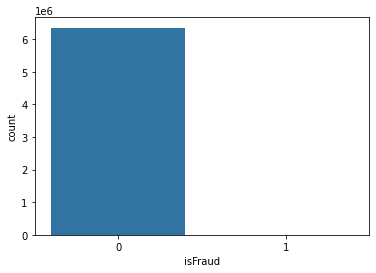

In [7]:
sns.countplot(x="isFraud", data=df)
print("Proportion of People Who Defaulted: {}".format(df["isFraud"].sum() / len(df)))

In [8]:
print ('\n The number of total fraudulents = {}'.\
       format(df["isFraud"].sum())) # 4116

print ('\n The number of total non fraudulents = {}'.\
       format(len(df) - df["isFraud"].sum())) # 4116


print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116




 The number of total fraudulents = 8213

 The number of total non fraudulents = 6354407

 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


In [9]:
print(df[df['isFraud'] == 1]['amount'].median())
print(df[df['isFraud'] == 1]['amount'].min())
print(df[df['isFraud'] == 1]['amount'].max())

441423.44
0.0
10000000.0


データセット内のすべてのトランザクションの0.12％である通常のトランザクションと比較して、不正のケースは非常に小さいことがわかります。
不正トランザクションも、TRANSFERおよびCASH_OUTトランズアクションタイプでのみ発生します。 今後のモデリングでは、これら2つのタイプのトランザクションのみがモデリングで使用されます。

### Flagged Fraud

In [10]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            # only 'TRANSFER'

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) # 353874.22

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) # 92445516.64


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


## Boxplot from IsFraud and IsFlaggedFraud

<AxesSubplot:title={'center':'amount'}, xlabel='isFraud'>

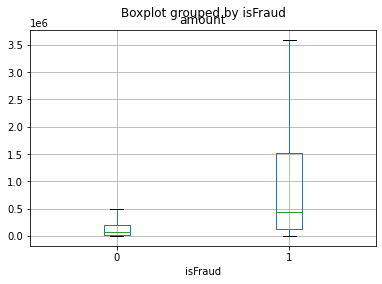

In [11]:
df.boxplot(by ='isFraud', column =['amount'], showfliers=False)
#sns.set_style("whitegrid")
#sns.boxplot(x = 'isFraud', y = 'amount', data = df)
#df['type'].value_counts()

<AxesSubplot:title={'center':'amount'}, xlabel='isFlaggedFraud'>

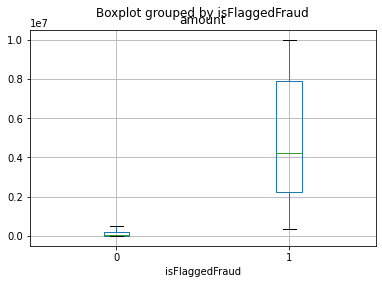

In [12]:
df.boxplot(by ='isFlaggedFraud', column =['amount'], showfliers=False)

<AxesSubplot:title={'center':'amount'}, xlabel='isFraud'>

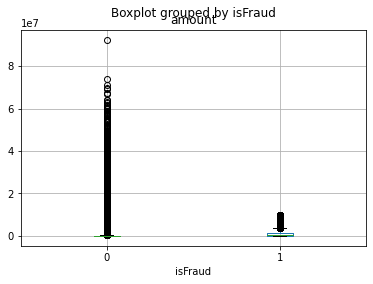

In [13]:
df.boxplot(by ='isFraud', column =['amount'])

<AxesSubplot:title={'center':'amount'}, xlabel='isFlaggedFraud'>

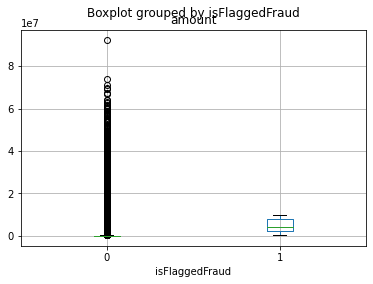

In [14]:
df.boxplot(by ='isFlaggedFraud', column =['amount'])

In [15]:
#sns.pairplot(df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']], hue = 'isFraud')
# pd.plotting.scatter_matrix(df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']],c = Y_train,figsize = (15,15),marker = 'o',
#                         hist_kwds={'bins':20},s=60,alpha=.8,cmap = mglearn.cm3)

### Step

From the step feature, we can see that all fraud is independent from time. 

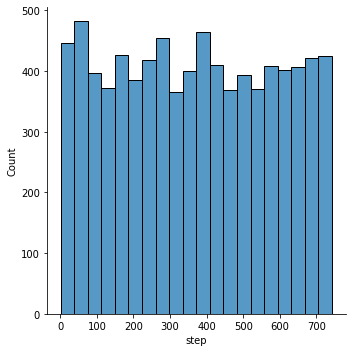

In [16]:
sns.displot(data=df[df['isFraud'] == 1], x="step")

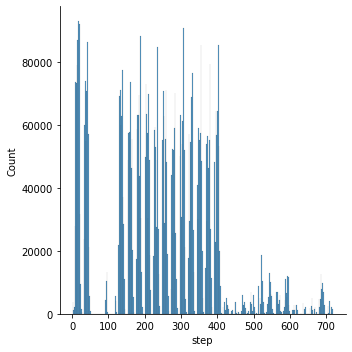

In [17]:
sns.displot(data=df[df['isFraud'] == 0], x="step")

In [18]:
print(len(df[(df['isFraud'] == 1) & (df['oldbalanceDest'] == 0) & (df['newbalanceDest'] == 0) & (df['amount'] !=0)]) / len(df[df['isFraud'] == 1]))
print(len(df[(df['isFraud'] == 1) & (df['newbalanceDest'] == 0) & (df['amount'] !=0)]) / len(df[df['isFraud'] == 1]))
print(len(df[(df['isFraud'] == 1) & (df['oldbalanceDest'] == 0) & (df['amount'] !=0)]) / len(df[df['isFraud'] == 1]))

print(len(df[(df['isFraud'] == 0) & (df['oldbalanceDest'] == 0) & (df['newbalanceDest'] == 0) & (df['amount'] !=0)]) / len(df[df['isFraud'] == 0]))
print(len(df[(df['isFraud'] == 0) & (df['newbalanceDest'] == 0) & (df['amount'] !=0)]) / len(df[df['isFraud'] == 0]))
print(len(df[(df['isFraud'] == 0) & (df['oldbalanceDest'] == 0) & (df['amount'] !=0)]) / len(df[df['isFraud'] == 0]))

0.4955558261293072
0.4973821989528796
0.65079751613296
0.36403176567065976
0.38325244196665403
0.4247504133745289


## isFraud vs isFlaggedFraud

isFlaggedFraud accuracy is: 99.87
isFlaggedFraud recall is: 100.00
isFlaggedFraud FPR is: 0.13
isFlaggedFraud precission is: 0.19
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6362604
           1       0.00      1.00      0.00        16

    accuracy                           1.00   6362620
   macro avg       0.50      1.00      0.50   6362620
weighted avg       1.00      1.00      1.00   6362620



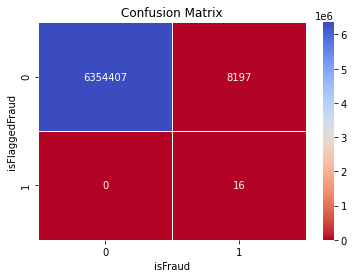

In [19]:
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

acc_gnb = (df['isFraud'] == df['isFlaggedFraud']).sum().astype(float) / len(df)*100
recall_gnb = recall_score(df['isFlaggedFraud'], df['isFraud'])
tnr_gnb = recall_score(df['isFlaggedFraud'], df['isFraud'], pos_label = 0)
fpr_gnb = 1 - tnr_gnb
print("isFlaggedFraud accuracy is: %3.2f" % (acc_gnb))
print("isFlaggedFraud recall is: %3.2f" % (recall_gnb*100))
print("isFlaggedFraud FPR is: %3.2f" % (fpr_gnb*100))
print("isFlaggedFraud precission is: %3.2f" % (precision_score(df['isFlaggedFraud'], df['isFraud'])*100))
cnf_matrix = metrics.confusion_matrix(df['isFlaggedFraud'], df['isFraud'])
print (metrics.classification_report(df['isFlaggedFraud'],df['isFraud']))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('isFlaggedFraud')
plt.xlabel('isFraud')
plt.savefig('cnf-NB.png')

In [20]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(df.loc[df.type == 'CASH_OUT'].nameOrig)]))


Fraudulent TRANSFERs whose destination accounts are originators of CASH_OUTs: 

         step      type      amount     nameOrig  oldbalanceOrg  \
1030443    65  TRANSFER  1282971.57  C1175896731     1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649      214793.32   
6362556   738  TRANSFER   814689.88  C2029041842      814689.88   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


In [21]:
print(df.loc[(df.type == 'CASH_OUT') & ((df.nameOrig =='C1714931087')|(df.nameOrig =='C423543548')|(df.nameOrig =='C1023330867'))])
# print(df.loc[(df.type == 'CASH_OUT') & (df.nameOrig =='C423543548')])
# print(df.loc[(df.type == 'CASH_OUT') & (df.nameOrig =='C1023330867')])

         step      type     amount     nameOrig  oldbalanceOrg  \
1168398   132  CASH_OUT   29084.28  C1023330867        51999.0   
2186261   185  CASH_OUT  214555.85   C423543548            0.0   
6149940   546  CASH_OUT   18091.05  C1714931087       197227.0   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
1168398        22914.72  C1422447255            0.00        29084.28        0   
2186261            0.00  C1066927674      4575179.83      4789735.69        0   
6149940       179135.95  C1339132632        66177.84        84268.89        0   

         isFlaggedFraud  
1168398               0  
2186261               0  
6149940               0  


isFlaggedFraudフィーチャーは、100％のリコールと0.19％のプレシジョン,で、すべての不正のうち16個しか読み取ることができません。 isFlaggedFraudのタイプは、TRANSFERタイプのトランザクションのみです。
今後、このフィーチャーは削除されます。

## 2. Feature Engineering

In [22]:
df_TC = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]


Proportion of People Who Defaulted: 0.002964544224336551


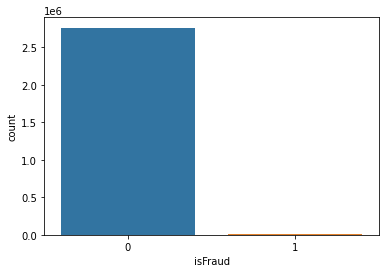

In [23]:
sns.countplot(x="isFraud", data=df_TC)
print("Proportion of People Who Defaulted: {}".format(df_TC["isFraud"].sum() / len(df_TC)))

In [24]:
print ('\n The number of total fraudulents = {}'.\
       format(df_TC["isFraud"].sum())) # 4116

print ('\n The number of total non fraudulents = {}'.\
       format(len(df_TC) - df_TC["isFraud"].sum())) # 4116


print('\n The types of fraudulent transactions are {}'.format(\
list(df_TC.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dfFraudTransfer = df_TC.loc[(df_TC.isFraud == 1) & (df_TC.type == 'TRANSFER')]
dfFraudCashout = df_TC.loc[(df_TC.isFraud == 1) & (df_TC.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) # 4116




 The number of total fraudulents = 8213

 The number of total non fraudulents = 2762196

 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


In [25]:
df_TC['errorBalanceOrig'] = df_TC['newbalanceOrig'] + df_TC['amount'] - df_TC['oldbalanceOrg']
df_TC['errorBalanceDest'] = df_TC['oldbalanceDest'] + df_TC['amount'] - df_TC['newbalanceDest']

<ipython-input-25-c926af73b069>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TC['errorBalanceOrig'] = df_TC['newbalanceOrig'] + df_TC['amount'] - df_TC['oldbalanceOrg']
<ipython-input-25-c926af73b069>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TC['errorBalanceDest'] = df_TC['oldbalanceDest'] + df_TC['amount'] - df_TC['newbalanceDest']


In [26]:
X = df_TC.drop(labels=['isFraud','nameOrig','nameDest','isFlaggedFraud'], axis=1)
Y = df_TC['isFraud']

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)

In [27]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,300850.89,-2401220.0


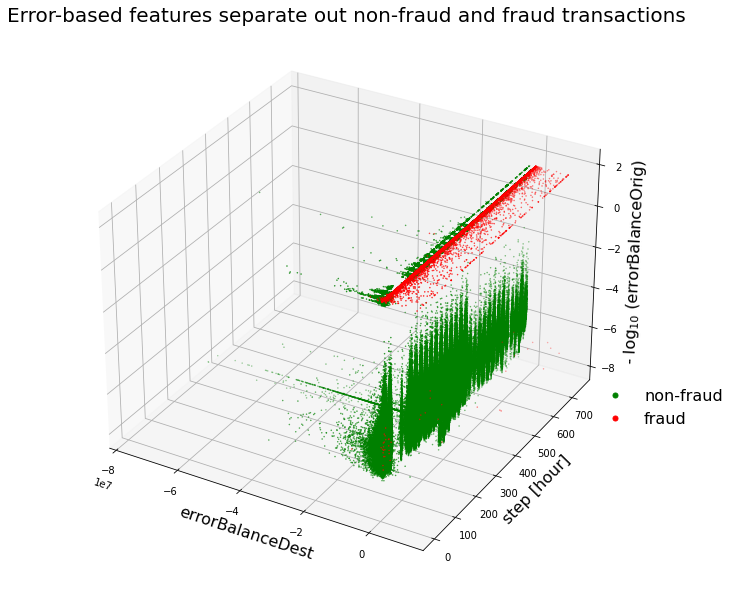

In [28]:
# Long computation in this cell (~2.5 minutes)
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'non-fraud')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraud')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out non-fraud and fraud \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='non-fraud')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraud')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

In [29]:
sns.scatterplot(data=df_TC,y='errorBalanceDest',x='errorBalanceOrig',hue='isFraud')

<AxesSubplot:xlabel='errorBalanceOrig', ylabel='errorBalanceDest'>

<AxesSubplot:title={'center':'errorBalanceDest'}, xlabel='isFraud'>

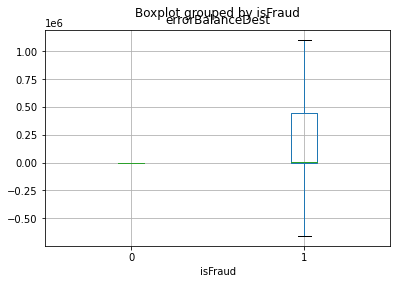

In [ ]:
df_TC.boxplot(by ='isFraud', column =['errorBalanceDest'],showfliers=False)


<AxesSubplot:title={'center':'errorBalanceOrig'}, xlabel='isFraud'>

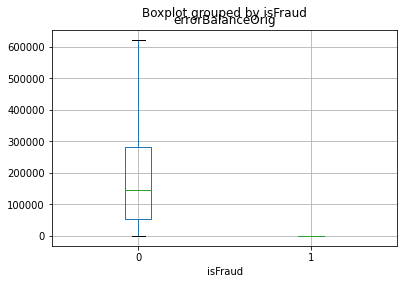

In [ ]:
df_TC.boxplot(by ='isFraud', column =['errorBalanceOrig'],showfliers=False)


In [ ]:
print(df_TC[df_TC['isFraud'] == 1]['errorBalanceDest'].min())
print(df_TC[df_TC['isFraud'] == 1]['errorBalanceDest'].max())
print(df_TC[df_TC['isFraud'] == 1]['errorBalanceOrig'].min())
print(df_TC[df_TC['isFraud'] == 1]['errorBalanceOrig'].max())


-8875516.29
10000000.0
-7.450580596923828e-09
10000000.0


In [ ]:
df_TC.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'errorBalanceOrig', 'errorBalanceDest'],
      dtype='object')

### Split Train, Validation and Backtesting

In [ ]:
from sklearn.model_selection import train_test_split
X_val, X_backtest, y_val, y_backtest = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val.shape, X_backtest.shape

((2216327, 9), (554082, 9))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_val, y_val, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((1662245, 9), (554082, 9))

In [ ]:
from collections import Counter
print('train', Counter(y_train))
print('test', Counter(y_test))
print('backtest', Counter(y_backtest))


train Counter({0: 1657268, 1: 4977})
test Counter({0: 552492, 1: 1590})
backtest Counter({0: 552436, 1: 1646})


#### Oversampling and Undersampling (SMOTEENN)

In [ ]:
from imblearn.combine import SMOTEENN
from collections import Counter

print('Before', Counter(y_train))

smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train,y_train)

print('after ',Counter(y_train_smenn))

Before Counter({0: 1657268, 1: 4977})
after  Counter({1: 1653653, 0: 1642026})


### Undersampling (Near Miss)

In [ ]:
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=3, n_neighbors_ver3=3)
print('Before', Counter(y_train))
X_train_cnn, y_train_cnn = undersample.fit_resample(X_train,y_train)
print('after ',Counter(y_train_cnn))

Before Counter({0: 1657268, 1: 4977})
after  Counter({1: 4977, 0: 3602})


C:\Users\nuzuf\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


### Oversampling (SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE

print('Before', Counter(y_train))

sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

print('after ',Counter(y_train_sm))

Before Counter({0: 1657268, 1: 4977})
after  Counter({0: 1657268, 1: 1657268})


### Pearson Correlation

#### Without Oversampling and Undersampling

<AxesSubplot:>

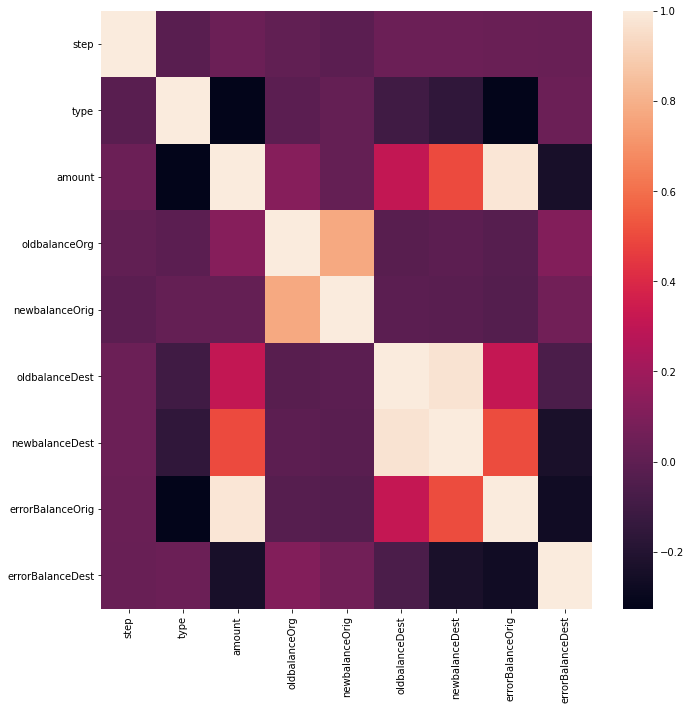

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#Using Pearson Correlation
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(X_train.corr())

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(X_train, 0.7)
corr_features

{'errorBalanceOrig', 'newbalanceDest', 'newbalanceOrig'}

In [ ]:
X_train_m = X_train.drop(corr_features,axis=1)
X_test_m = X_test.drop(corr_features,axis=1)

<AxesSubplot:>

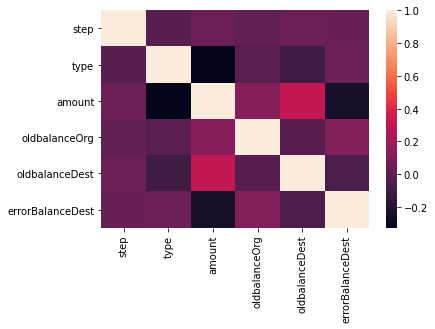

In [ ]:
sns.heatmap(X_train_m.corr())

#### with Hybridization (Oversampling + Undersampling)

<AxesSubplot:>

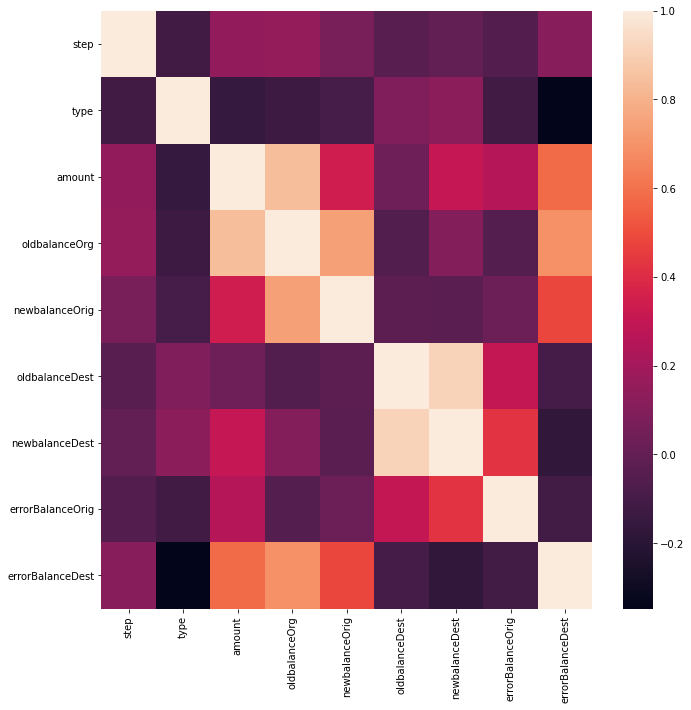

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(X_train_smenn.corr())

In [ ]:
corr_features = correlation(X_train_smenn, 0.7)
corr_features

{'newbalanceDest', 'newbalanceOrig', 'oldbalanceOrg'}

In [ ]:
X_train_smenn_m = X_train_smenn.drop(corr_features,axis=1)
X_test_smenn_m = X_test.drop(corr_features,axis=1)

#### with Oversampling

<AxesSubplot:>

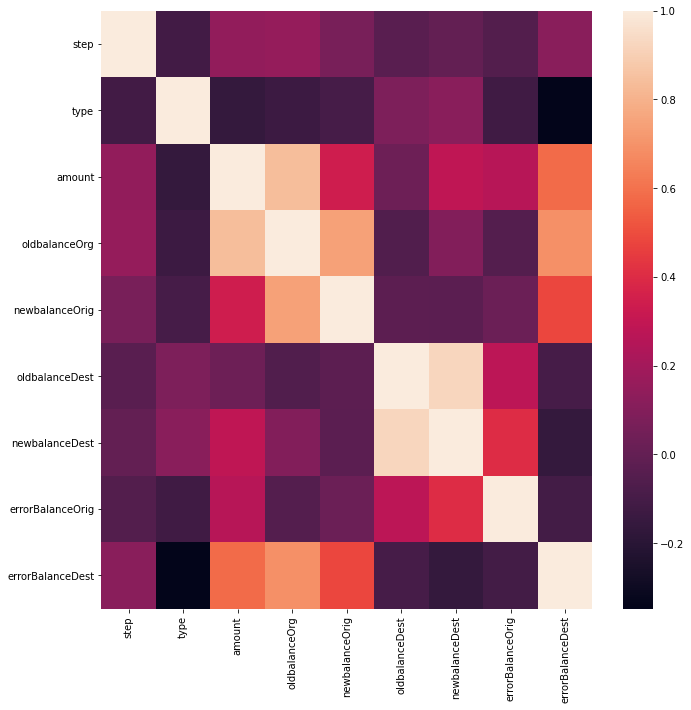

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(X_train_sm.corr())

In [ ]:
corr_features = correlation(X_train_sm, 0.7)
corr_features

{'newbalanceDest', 'newbalanceOrig', 'oldbalanceOrg'}

In [ ]:
X_train_sm_m = X_train_sm.drop(corr_features,axis=1)
X_test_sm_m = X_test.drop(corr_features,axis=1)

#### with Undersampling

<AxesSubplot:>

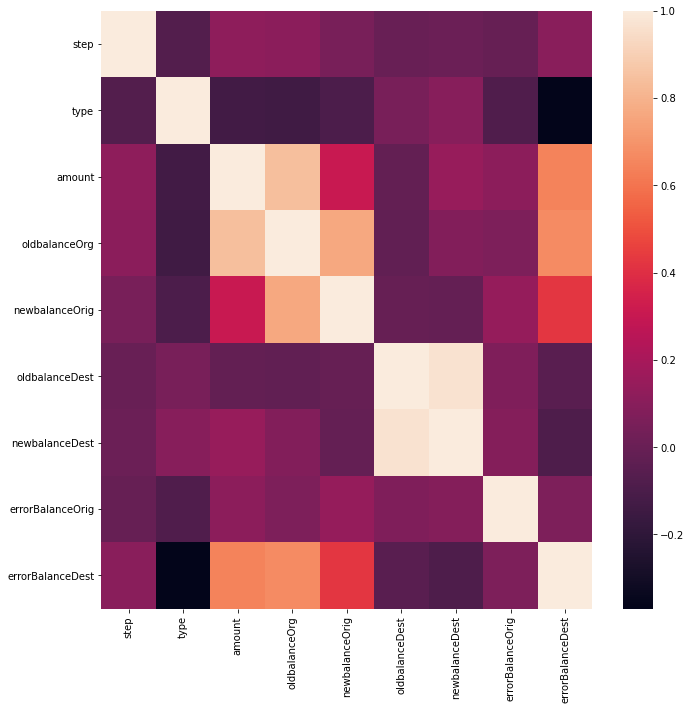

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(X_train_cnn.corr())

In [ ]:
corr_features = correlation(X_train_cnn, 0.7)
corr_features

{'newbalanceDest', 'newbalanceOrig', 'oldbalanceOrg'}

In [ ]:
X_train_cnn_m = X_train_cnn.drop(corr_features,axis=1)
X_test_cnn_m = X_test.drop(corr_features,axis=1)

### PCA

#### without oversampling and undersampling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_rescaled_train = scaler.fit_transform(X_train)
X_rescaled_test = scaler.fit_transform(X_test)

Text(0, 0.5, 'cumulative explained variance')

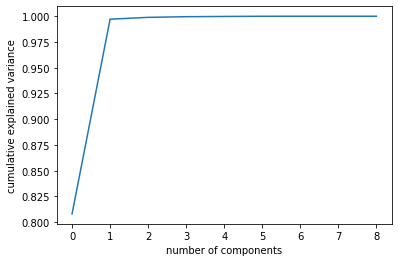

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_rescaled_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')



In [ ]:
pca.components_.shape

(9, 9)

In [ ]:
numb = np.arange(1,9)
numb

array([1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
# sum = 0
# for a in pca.explained_variance_ratio_:
#     print(sum)
#     sum += a
np.cumsum(pca.explained_variance_ratio_)

array([0.80804011, 0.99713197, 0.99891829, 0.99955492, 0.99980431,
       0.99997633, 1.        , 1.        , 1.        ])

In [ ]:
cumvar = pd.DataFrame({'number of components': np.arange(1,9), 'explained variance ratio': np.cumsum(pca.explained_variance_ratio_)[1:]})
cumvar

,number of components,explained variance ratio
0,1,0.997132
1,2,0.998918
2,3,0.999555
3,4,0.999804
4,5,0.999976
5,6,1.000000
6,7,1.000000
7,8,1.000000


In [ ]:
pca = PCA(n_components=5)
X_pca_train = pca.fit_transform(X_rescaled_train)
X_pca_test = pca.transform(X_rescaled_test)
X_pca_train

array([[ 8.08791973e-01,  1.33605275e-01, -1.32561516e-02,
        -4.58586666e-04,  4.27354234e-04],
       [ 8.07692852e-01,  1.63897083e-02, -5.01684340e-03,
        -4.09976547e-03,  1.12307947e-04],
       [ 8.09387409e-01,  1.78189584e-01,  1.83466325e-02,
        -2.36802197e-02,  1.77362453e-03],
       ...,
       [-1.90706940e-01,  1.85252411e-01, -4.32350951e-03,
         3.24956397e-03,  2.05725932e-04],
       [-1.93324700e-01, -8.02315631e-02, -3.34935808e-03,
         2.45757963e-03, -1.59328338e-04],
       [-1.91689380e-01,  8.68724728e-02, -4.55750761e-03,
         2.13077098e-03,  3.03120104e-04]])

In [ ]:
X_pca_train_ = pd.DataFrame(data=X_pca_train,columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
X_pca_test_ = pd.DataFrame(data=X_pca_test,columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
X_pca_train_ = X_pca_train_ #.drop(labels=['PC1'],axis=1)
X_pca_test_ = X_pca_test_ #.drop(labels=['PC1'],axis=1)
X_pca_train_.head()


,PC1,PC2,PC3,PC4,PC5
0,0.808792,0.133605,-0.013256,-0.000459,0.000427
1,0.807693,0.016390,-0.005017,-0.004100,0.000112
2,0.809387,0.178190,0.018347,-0.023680,0.001774
3,-0.192703,-0.019581,-0.002069,0.003691,-0.001555
4,-0.190782,0.174481,-0.001814,0.003965,-0.000153


In [ ]:
print(X_pca_train_.shape)
print(X_pca_test_.shape)

(1662245, 5)
(554082, 5)


#### with oversampling

In [ ]:
scaler = MinMaxScaler()
X_rescaled_train_sm = scaler.fit_transform(X_train_sm)


Text(0, 0.5, 'cumulative explained variance')

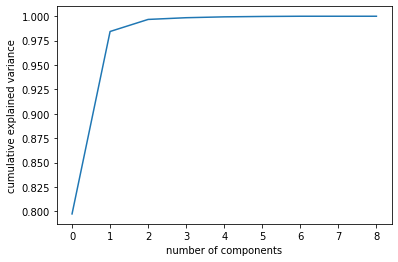

In [ ]:
pca = PCA().fit(X_rescaled_train_sm)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
cumvar01 = pd.DataFrame({'number of components': np.arange(1,9), 'explained variance ratio': np.cumsum(pca.explained_variance_ratio_)[1:]})
cumvar01

,number of components,explained variance ratio
0,1,0.984372
1,2,0.996737
2,3,0.998496
3,4,0.999371
4,5,0.999777
5,6,1.000000
6,7,1.000000
7,8,1.000000


In [ ]:
pca = PCA(n_components=5)
X_pca_train_sm = pca.fit_transform(X_rescaled_train_sm)
X_pca_test_sm = pca.transform(X_rescaled_test)
X_pca_train_sm

array([[ 0.65414516,  0.0071808 , -0.02911393,  0.00572405,  0.00208103],
       [ 0.6455181 , -0.10967082, -0.02466285,  0.00338942,  0.00949068],
       [ 0.65721463,  0.05139624, -0.03296234,  0.0028436 ,  0.03522732],
       ...,
       [ 0.64814653, -0.07588877, -0.02070339,  0.00479186, -0.00224519],
       [ 0.62700894, -0.36091409, -0.01769093,  0.00644177, -0.00147259],
       [-0.33523628,  0.16197502,  0.09330167, -0.05011781,  0.00305017]])

In [ ]:
X_pca_train_sm_ = pd.DataFrame(data=X_pca_train_sm,columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
X_pca_train_sm_ = X_pca_train_sm_ #.drop(labels=['PC1'],axis=1)
X_pca_train_sm_.head()

,PC1,PC2,PC3,PC4,PC5
0,0.654145,0.007181,-0.029114,0.005724,0.002081
1,0.645518,-0.109671,-0.024663,0.003389,0.009491
2,0.657215,0.051396,-0.032962,0.002844,0.035227
3,-0.354851,-0.081239,-0.003908,0.002845,-0.003254
4,-0.340682,0.112026,-0.014672,0.005221,-0.001556


## MODEL and Evaluation

### All Feature

#### without oversampling

##### XGBoost

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)


NameError: name 'X_train' is not defined

In [ ]:
y_pred = xgb.predict(X_test)


Scikit-Learn's XGBoost's prediction accuracy is: 100.00
Scikit-Learn's XGBoost's prediction recall is: 1.00
Scikit-Learn's XGBoost's prediction FPR is: 0.00
Scikit-Learn's XGBoost's prediction Precision is: 1.00
Scikit-Learn's XGBoost's prediction auc_score is: 1.00
Scikit-Learn's XGBoost's prediction fnr is: 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       1.00      1.00      1.00      1590

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



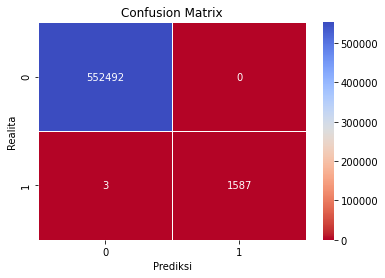

In [ ]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

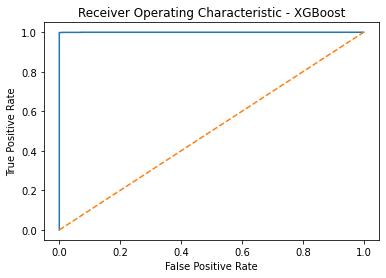

In [ ]:
y_score = xgb.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

##### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 100.00
Scikit-Learn's Random Forest Classifier's prediction recall is: 1.00
Scikit-Learn's Random Forests Classifier's prediction FPR is: 0.00
Scikit-Learn's Random Forests Classifier's prediction Precision is: 1.00
Scikit-Learn's Random Forests Classifier's prediction auc_score is: 1.00
Scikit-Learn's Random Forests Classifier's prediction fnr is: 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       1.00      1.00      1.00      1590

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



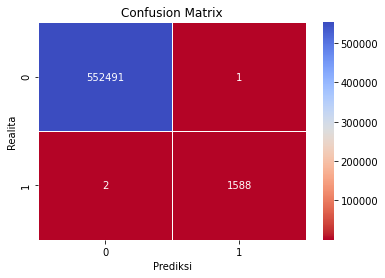

In [35]:
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_rfc = recall_score(y_test, y_pred)
tnr_rfc = recall_score(y_test, y_pred, pos_label = 0)
fpr_rfc = 1 - tnr_rfc
prec_rfc = precision_score(y_test, y_pred)
auc_rfc = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction recall is: %3.2f" % (recall_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction FPR is: %3.2f" % (fpr_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction Precision is: %3.2f" % (prec_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction auc_score is: %3.2f" % (auc_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction fnr is: %3.2f" % (1-recall_rfc))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

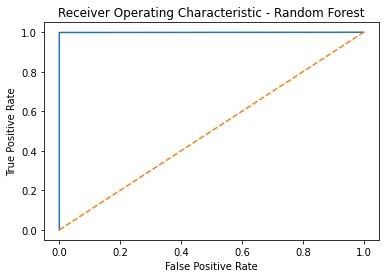

In [36]:
y_score = rfc.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

##### SVM

In [37]:
# from sklearn.svm import SVC
# svc = SVC(probability=True)
# svc.fit(X_train, y_train)
# y_pred = svc.predict(X_test)


In [38]:
# acc_svc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
# recall_svc = recall_score(y_test, y_pred)
# tnr_svc = recall_score(y_test, y_pred, pos_label = 0)
# fpr_svc = 1 - tnr_svc
# prec_svc = precision_score(y_test, y_pred)
# auc_svc = roc_auc_score(y_test, y_pred)
# print("Scikit-Learn's SVC's prediction accuracy is: %3.2f" % (acc_svc))
# print("Scikit-Learn's SVC's prediction recall is: %3.2f" % (recall_svc))
# print("Scikit-Learn's SVC's prediction FPR is: %3.2f" % (fpr_svc))
# print("Scikit-Learn's SVC's prediction Precision is: %3.2f" % (prec_svc))
# print("Scikit-Learn's SVC's prediction auc_score is: %3.2f" % (auc_svc))
# print("Scikit-Learn's SVC's prediction fnr is: %3.2f" % (1-recall_svc))

# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# print (metrics.classification_report(y_test,y_pred))
# sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
# plt.title('Confusion Matrix')
# plt.xlabel('Prediksi')
# plt.ylabel('Realita')
# plt.savefig('cnf-SVM.png')

In [39]:
# y_score = svc.predict_proba(X_test)[:,1]
# false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

# plt.title('Receiver Operating Characteristic - SVM')
# plt.plot(false_positive_rate, true_positive_rate)
# plt.plot([0, 1], ls="--")
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')

# plt.savefig('ROC_SVM.png',dpi=100)
# plt.show()

##### Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(class_weight='auto',max_iter=10000)
model=logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

Scikit-Learn's Logistic Regression's prediction accuracy is: 99.69
Scikit-Learn's Logistic Regression's prediction recall is: 0.43
Scikit-Learn's Logistic Regression's prediction FPR is: 0.00
Scikit-Learn's Logistic Regression's prediction Precision is: 0.45
Scikit-Learn's Logistic Regression's prediction auc_score is: 0.71
Scikit-Learn's Logistic Regression's prediction fnr is: 0.57
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       0.45      0.43      0.44      1590

    accuracy                           1.00    554082
   macro avg       0.73      0.71      0.72    554082
weighted avg       1.00      1.00      1.00    554082



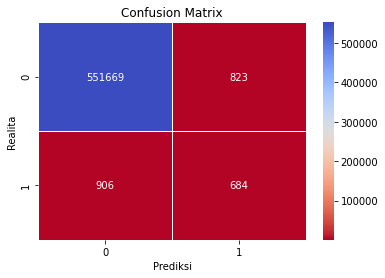

In [41]:
acc_logreg = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_logreg = recall_score(y_test, y_pred)
tnr_logreg = recall_score(y_test, y_pred, pos_label = 0)
fpr_logreg = 1 - tnr_logreg
prec_logreg = precision_score(y_test, y_pred)
auc_logreg = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Logistic Regression's prediction accuracy is: %3.2f" % (acc_logreg))
print("Scikit-Learn's Logistic Regression's prediction recall is: %3.2f" % (recall_logreg))
print("Scikit-Learn's Logistic Regression's prediction FPR is: %3.2f" % (fpr_logreg))
print("Scikit-Learn's Logistic Regression's prediction Precision is: %3.2f" % (prec_logreg))
print("Scikit-Learn's Logistic Regression's prediction auc_score is: %3.2f" % (auc_logreg))
print("Scikit-Learn's Logistic Regression's prediction fnr is: %3.2f" % (1-recall_logreg))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-logreg.png')

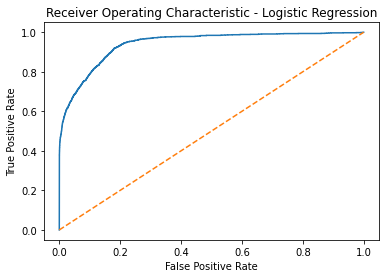

In [42]:
y_score = logreg.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_Logistic.png',dpi=100)
plt.show()

In [43]:
results = pd.DataFrame({
    'Model': [ 
              'XGBoost', 'Random Forest','Logistic Regression'],
    'Recall': [ recall_xgb, recall_rfc,recall_logreg],
    'FPR': [ fpr_xgb, fpr_rfc, fpr_logreg],
    'Accuracy': [ acc_xgb, acc_rfc, acc_logreg],
    'Precission':[ prec_xgb, prec_rfc, prec_logreg],
    'AUC_ROC':[ auc_xgb, auc_rfc, auc_logreg],
    'FNR':[1-recall_xgb, 1-recall_rfc, 1-recall_logreg]})
result_df = results.sort_values(by='Recall', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Recall,FPR,Accuracy,Precission,AUC_ROC,FNR
Model,,,,,,
Random Forest,0.998742,0.000002,99.999459,0.999371,0.999370,0.001258
XGBoost,0.998113,0.000000,99.999459,1.000000,0.999057,0.001887
Logistic Regression,0.430189,0.001490,99.687952,0.453882,0.714350,0.569811


#### with Hybridization

##### XGBoost

In [44]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_smenn, y_train_smenn)


C:\Users\nuzuf\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:55:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
y_pred = xgb.predict(X_test)


Scikit-Learn's XGBoost's prediction accuracy is: 99.99
Scikit-Learn's XGBoost's prediction recall is: 1.00
Scikit-Learn's XGBoost's prediction FPR is: 0.00
Scikit-Learn's XGBoost's prediction Precision is: 0.97
Scikit-Learn's XGBoost's prediction auc_score is: 1.00
Scikit-Learn's XGBoost's prediction fnr is: 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       0.97      1.00      0.98      1590

    accuracy                           1.00    554082
   macro avg       0.98      1.00      0.99    554082
weighted avg       1.00      1.00      1.00    554082



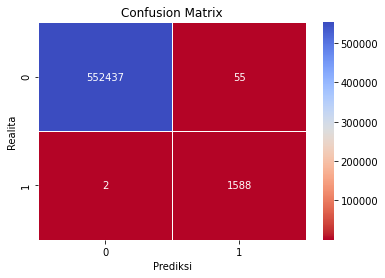

In [46]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

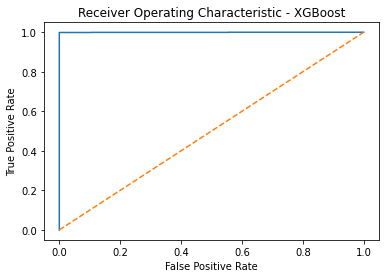

In [47]:
y_score = xgb.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

##### Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train_smenn, y_train_smenn)
y_pred = rfc.predict(X_test)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 99.99
Scikit-Learn's Random Forest Classifier's prediction recall is: 1.00
Scikit-Learn's Random Forests Classifier's prediction FPR is: 0.00
Scikit-Learn's Random Forests Classifier's prediction Precision is: 0.97
Scikit-Learn's Random Forests Classifier's prediction auc_score is: 1.00
Scikit-Learn's Random Forests Classifier's prediction fnr is: 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       0.97      1.00      0.98      1590

    accuracy                           1.00    554082
   macro avg       0.99      1.00      0.99    554082
weighted avg       1.00      1.00      1.00    554082



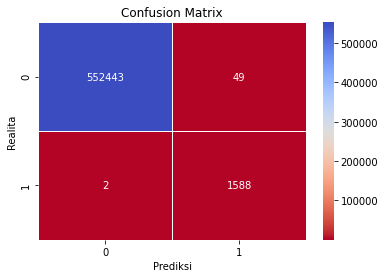

In [49]:
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_rfc = recall_score(y_test, y_pred)
tnr_rfc = recall_score(y_test, y_pred, pos_label = 0)
fpr_rfc = 1 - tnr_rfc
prec_rfc = precision_score(y_test, y_pred)
auc_rfc = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction recall is: %3.2f" % (recall_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction FPR is: %3.2f" % (fpr_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction Precision is: %3.2f" % (prec_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction auc_score is: %3.2f" % (auc_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction fnr is: %3.2f" % (1-recall_rfc))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

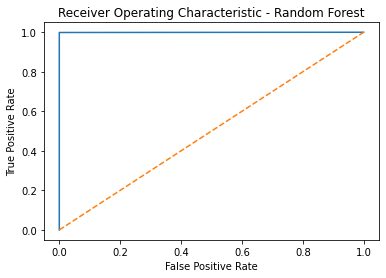

In [50]:
y_score = rfc.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

##### SVM

In [51]:
# from sklearn.svm import SVC
# svc = SVC(probability=True)
# svc.fit(X_train_smenn, y_train_smenn)
# y_pred = svc.predict(X_test)


In [52]:
# acc_svc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
# recall_svc = recall_score(y_test, y_pred)
# tnr_svc = recall_score(y_test, y_pred, pos_label = 0)
# fpr_svc = 1 - tnr_svc
# prec_svc = precision_score(y_test, y_pred)
# auc_svc = roc_auc_score(y_test, y_pred)
# print("Scikit-Learn's SVC's prediction accuracy is: %3.2f" % (acc_svc))
# print("Scikit-Learn's SVC's prediction recall is: %3.2f" % (recall_svc))
# print("Scikit-Learn's SVC's prediction FPR is: %3.2f" % (fpr_svc))
# print("Scikit-Learn's SVC's prediction Precision is: %3.2f" % (prec_svc))
# print("Scikit-Learn's SVC's prediction auc_score is: %3.2f" % (auc_svc))
# print("Scikit-Learn's SVC's prediction fnr is: %3.2f" % (1-recall_svc))

# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# print (metrics.classification_report(y_test,y_pred))
# sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
# plt.title('Confusion Matrix')
# plt.xlabel('Prediksi')
# plt.ylabel('Realita')
# plt.savefig('cnf-SVM.png')

In [53]:
# y_score = svc.predict_proba(X_test)[:,1]
# false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

# plt.title('Receiver Operating Characteristic - SVM')
# plt.plot(false_positive_rate, true_positive_rate)
# plt.plot([0, 1], ls="--")
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')

# plt.savefig('ROC_SVM.png',dpi=100)
# plt.show()

##### Logistic Regression

In [54]:
logreg = LogisticRegression(class_weight='auto',max_iter=10000)
model=logreg.fit(X_train_smenn, y_train_smenn)
y_pred=logreg.predict(X_test)

Scikit-Learn's Logistic Regression's prediction accuracy is: 90.28
Scikit-Learn's Logistic Regression's prediction recall is: 0.97
Scikit-Learn's Logistic Regression's prediction FPR is: 0.10
Scikit-Learn's Logistic Regression's prediction Precision is: 0.03
Scikit-Learn's Logistic Regression's prediction auc_score is: 0.94
Scikit-Learn's Logistic Regression's prediction fnr is: 0.03
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    552492
           1       0.03      0.97      0.05      1590

    accuracy                           0.90    554082
   macro avg       0.51      0.94      0.50    554082
weighted avg       1.00      0.90      0.95    554082



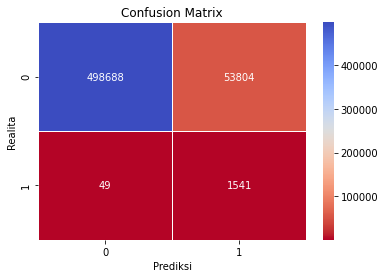

In [55]:
acc_logreg = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_logreg = recall_score(y_test, y_pred)
tnr_logreg = recall_score(y_test, y_pred, pos_label = 0)
fpr_logreg = 1 - tnr_logreg
prec_logreg = precision_score(y_test, y_pred)
auc_logreg = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Logistic Regression's prediction accuracy is: %3.2f" % (acc_logreg))
print("Scikit-Learn's Logistic Regression's prediction recall is: %3.2f" % (recall_logreg))
print("Scikit-Learn's Logistic Regression's prediction FPR is: %3.2f" % (fpr_logreg))
print("Scikit-Learn's Logistic Regression's prediction Precision is: %3.2f" % (prec_logreg))
print("Scikit-Learn's Logistic Regression's prediction auc_score is: %3.2f" % (auc_logreg))
print("Scikit-Learn's Logistic Regression's prediction fnr is: %3.2f" % (1-recall_logreg))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-logreg.png')

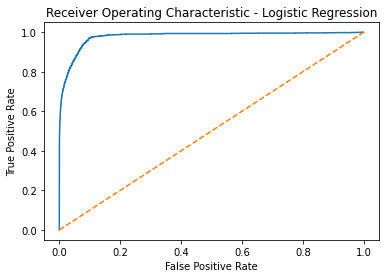

In [56]:
y_score = logreg.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_Logistic.png',dpi=100)
plt.show()

In [57]:
results = pd.DataFrame({
    'Model': [ 
              'XGBoost', 'Random Forest','Logistic Regression'],
    'Recall': [ recall_xgb, recall_rfc,recall_logreg],
    'FPR': [ fpr_xgb, fpr_rfc, fpr_logreg],
    'Accuracy': [ acc_xgb, acc_rfc, acc_logreg],
    'Precission':[ prec_xgb, prec_rfc, prec_logreg],
    'AUC_ROC':[ auc_xgb, auc_rfc, auc_logreg],
    'FNR':[1-recall_xgb, 1-recall_rfc, 1-recall_logreg]})
result_df = results.sort_values(by='Recall', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Recall,FPR,Accuracy,Precission,AUC_ROC,FNR
Model,,,,,,
XGBoost,0.998742,0.000100,99.989713,0.966525,0.999321,0.001258
Random Forest,0.998742,0.000089,99.990796,0.970067,0.999327,0.001258
Logistic Regression,0.969182,0.097384,90.280680,0.027844,0.935899,0.030818


#### with oversampling

##### XGBoost

In [58]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_sm, y_train_sm)
y_pred = xgb.predict(X_test)

C:\Users\nuzuf\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:00:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Scikit-Learn's XGBoost's prediction accuracy is: 99.99
Scikit-Learn's XGBoost's prediction recall is: 1.00
Scikit-Learn's XGBoost's prediction FPR is: 0.00
Scikit-Learn's XGBoost's prediction Precision is: 0.97
Scikit-Learn's XGBoost's prediction auc_score is: 1.00
Scikit-Learn's XGBoost's prediction fnr is: 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       0.97      1.00      0.98      1590

    accuracy                           1.00    554082
   macro avg       0.98      1.00      0.99    554082
weighted avg       1.00      1.00      1.00    554082



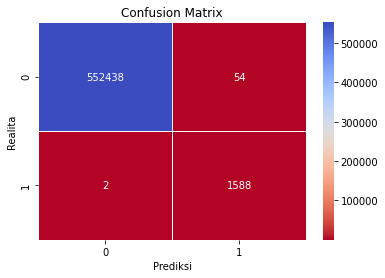

In [59]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

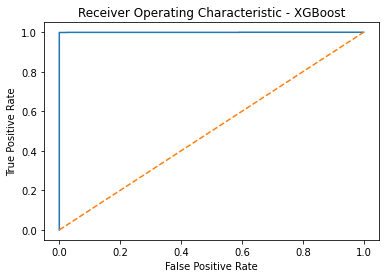

In [60]:
y_score = xgb.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

##### Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train_sm, y_train_sm)
y_pred = rfc.predict(X_test)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 99.99
Scikit-Learn's Random Forest Classifier's prediction recall is: 1.00
Scikit-Learn's Random Forests Classifier's prediction FPR is: 0.00
Scikit-Learn's Random Forests Classifier's prediction Precision is: 0.98
Scikit-Learn's Random Forests Classifier's prediction auc_score is: 1.00
Scikit-Learn's Random Forests Classifier's prediction fnr is: 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       0.98      1.00      0.99      1590

    accuracy                           1.00    554082
   macro avg       0.99      1.00      0.99    554082
weighted avg       1.00      1.00      1.00    554082



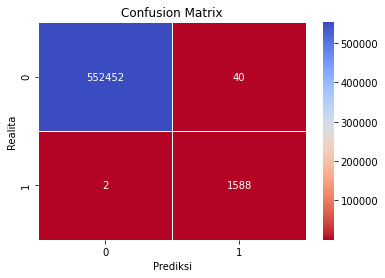

In [62]:
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_rfc = recall_score(y_test, y_pred)
tnr_rfc = recall_score(y_test, y_pred, pos_label = 0)
fpr_rfc = 1 - tnr_rfc
prec_rfc = precision_score(y_test, y_pred)
auc_rfc = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction recall is: %3.2f" % (recall_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction FPR is: %3.2f" % (fpr_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction Precision is: %3.2f" % (prec_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction auc_score is: %3.2f" % (auc_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction fnr is: %3.2f" % (1-recall_rfc))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

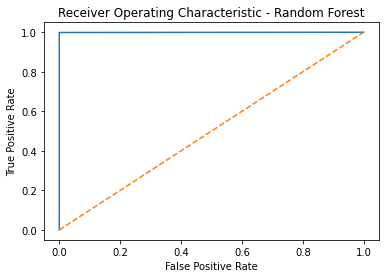

In [63]:
y_score = rfc.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

##### Logistic Regression

In [64]:
logreg = LogisticRegression(class_weight='auto',max_iter=10000)
model=logreg.fit(X_train_sm, y_train_sm)
y_pred=logreg.predict(X_test)

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 90.23
Scikit-Learn's Gaussian Naive Bayes Classifier's prediction recall is: 0.97
Scikit-Learn's Gaussian Naive Bayes Classifier's prediction FPR is: 0.10
Scikit-Learn's SVC's prediction Precision is: 0.03
Scikit-Learn's SVC's prediction auc_score is: 0.94
Scikit-Learn's SVC's prediction fnr is: 0.03
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    552492
           1       0.03      0.97      0.05      1590

    accuracy                           0.90    554082
   macro avg       0.51      0.94      0.50    554082
weighted avg       1.00      0.90      0.95    554082



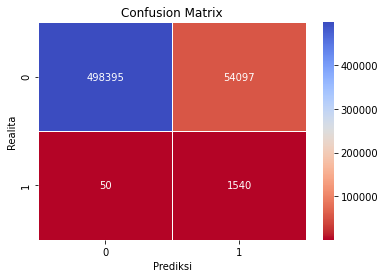

In [65]:
acc_logreg = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_logreg = recall_score(y_test, y_pred)
tnr_logreg = recall_score(y_test, y_pred, pos_label = 0)
fpr_logreg = 1 - tnr_logreg
prec_logreg = precision_score(y_test, y_pred)
auc_logreg = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_logreg))
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction recall is: %3.2f" % (recall_logreg))
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction FPR is: %3.2f" % (fpr_logreg))
print("Scikit-Learn's SVC's prediction Precision is: %3.2f" % (prec_logreg))
print("Scikit-Learn's SVC's prediction auc_score is: %3.2f" % (auc_logreg))
print("Scikit-Learn's SVC's prediction fnr is: %3.2f" % (1-recall_logreg))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-logreg.png')

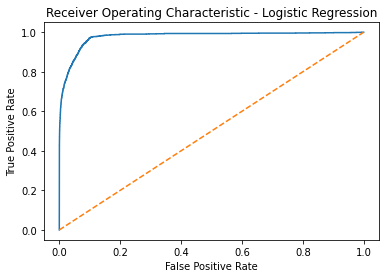

In [66]:
y_score = logreg.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_Logistic.png',dpi=100)
plt.show()

In [67]:
results = pd.DataFrame({
    'Model': [ 
              'XGBoost', 'Random Forest','Logistic Regression'],
    'Recall': [ recall_xgb, recall_rfc,recall_logreg],
    'FPR': [ fpr_xgb, fpr_rfc, fpr_logreg],
    'Accuracy': [ acc_xgb, acc_rfc, acc_logreg],
    'Precission':[ prec_xgb, prec_rfc, prec_logreg],
    'AUC_ROC':[ auc_xgb, auc_rfc, auc_logreg],
    'FNR':[1-recall_xgb, 1-recall_rfc, 1-recall_logreg]})
result_df = results.sort_values(by='Recall', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Recall,FPR,Accuracy,Precission,AUC_ROC,FNR
Model,,,,,,
XGBoost,0.998742,0.000098,99.989893,0.967113,0.999322,0.001258
Random Forest,0.998742,0.000072,99.992420,0.975430,0.999335,0.001258
Logistic Regression,0.968553,0.097915,90.227620,0.027679,0.935319,0.031447


#### with undersampling

##### XGBoost

In [69]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_cnn, y_train_cnn)
y_pred = xgb.predict(X_test)

C:\Users\nuzuf\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:10:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Scikit-Learn's XGBoost's prediction accuracy is: 96.18
Scikit-Learn's XGBoost's prediction recall is: 1.00
Scikit-Learn's XGBoost's prediction FPR is: 0.04
Scikit-Learn's XGBoost's prediction Precision is: 0.07
Scikit-Learn's XGBoost's prediction auc_score is: 0.98
Scikit-Learn's XGBoost's prediction fnr is: 0.00
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    552492
           1       0.07      1.00      0.13      1590

    accuracy                           0.96    554082
   macro avg       0.53      0.98      0.56    554082
weighted avg       1.00      0.96      0.98    554082



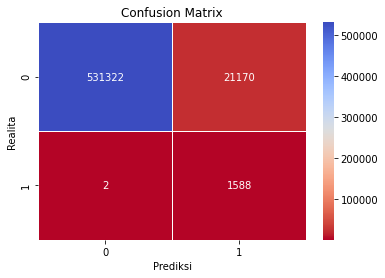

In [70]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

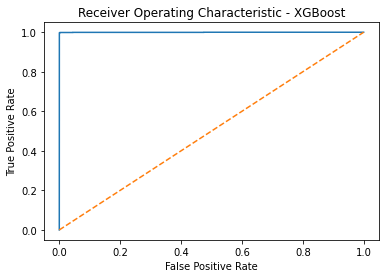

In [71]:
y_score = xgb.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

##### Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train_cnn, y_train_cnn)
y_pred = rfc.predict(X_test)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 99.58
Scikit-Learn's Random Forest Classifier's prediction recall is: 1.00
Scikit-Learn's Random Forests Classifier's prediction FPR is: 0.00
Scikit-Learn's Random Forests Classifier's prediction Precision is: 0.40
Scikit-Learn's Random Forests Classifier's prediction auc_score is: 1.00
Scikit-Learn's Random Forests Classifier's prediction fnr is: 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       0.40      1.00      0.58      1590

    accuracy                           1.00    554082
   macro avg       0.70      1.00      0.79    554082
weighted avg       1.00      1.00      1.00    554082



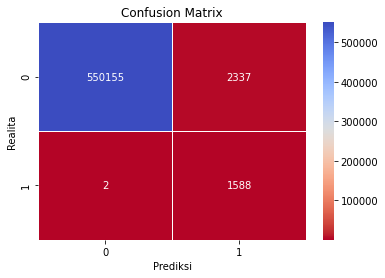

In [73]:
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_rfc = recall_score(y_test, y_pred)
tnr_rfc = recall_score(y_test, y_pred, pos_label = 0)
fpr_rfc = 1 - tnr_rfc
prec_rfc = precision_score(y_test, y_pred)
auc_rfc = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction recall is: %3.2f" % (recall_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction FPR is: %3.2f" % (fpr_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction Precision is: %3.2f" % (prec_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction auc_score is: %3.2f" % (auc_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction fnr is: %3.2f" % (1-recall_rfc))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

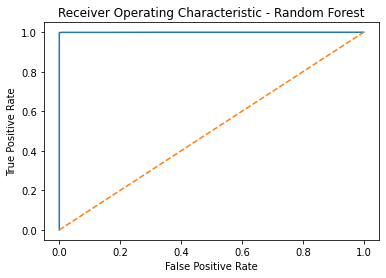

In [74]:
y_score = rfc.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

##### Logistic Regression

In [75]:
logreg = LogisticRegression(class_weight='auto',max_iter=10000)
model=logreg.fit(X_train_cnn, y_train_cnn)
y_pred=logreg.predict(X_test)

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 93.84
Scikit-Learn's Gaussian Naive Bayes Classifier's prediction recall is: 0.91
Scikit-Learn's Gaussian Naive Bayes Classifier's prediction FPR is: 0.06
Scikit-Learn's SVC's prediction Precision is: 0.04
Scikit-Learn's SVC's prediction auc_score is: 0.93
Scikit-Learn's SVC's prediction fnr is: 0.09
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    552492
           1       0.04      0.91      0.08      1590

    accuracy                           0.94    554082
   macro avg       0.52      0.93      0.52    554082
weighted avg       1.00      0.94      0.97    554082



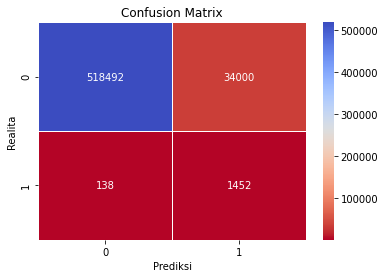

In [76]:
acc_logreg = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_logreg = recall_score(y_test, y_pred)
tnr_logreg = recall_score(y_test, y_pred, pos_label = 0)
fpr_logreg = 1 - tnr_logreg
prec_logreg = precision_score(y_test, y_pred)
auc_logreg = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_logreg))
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction recall is: %3.2f" % (recall_logreg))
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction FPR is: %3.2f" % (fpr_logreg))
print("Scikit-Learn's SVC's prediction Precision is: %3.2f" % (prec_logreg))
print("Scikit-Learn's SVC's prediction auc_score is: %3.2f" % (auc_logreg))
print("Scikit-Learn's SVC's prediction fnr is: %3.2f" % (1-recall_logreg))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-logreg.png')

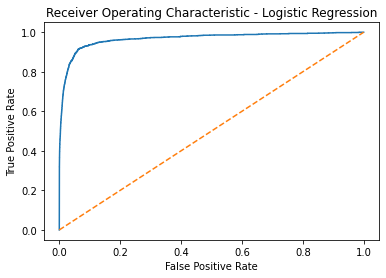

In [77]:
y_score = logreg.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_Logistic.png',dpi=100)
plt.show()

In [78]:
results = pd.DataFrame({
    'Model': [ 
              'XGBoost', 'Random Forest','Logistic Regression'],
    'Recall': [ recall_xgb, recall_rfc,recall_logreg],
    'FPR': [ fpr_xgb, fpr_rfc, fpr_logreg],
    'Accuracy': [ acc_xgb, acc_rfc, acc_logreg],
    'Precission':[ prec_xgb, prec_rfc, prec_logreg],
    'AUC_ROC':[ auc_xgb, auc_rfc, auc_logreg],
    'FNR':[1-recall_xgb, 1-recall_rfc, 1-recall_logreg]})
result_df = results.sort_values(by='Recall', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Recall,FPR,Accuracy,Precission,AUC_ROC,FNR
Model,,,,,,
XGBoost,0.998742,0.038317,96.178905,0.069778,0.980212,0.001258
Random Forest,0.998742,0.004230,99.577860,0.404586,0.997256,0.001258
Logistic Regression,0.913208,0.061539,93.838818,0.040957,0.925834,0.086792


### by Feature Selection

#### without oversampling

##### XGBoost

In [79]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_m, y_train)
y_pred = xgb.predict(X_test_m)

C:\Users\nuzuf\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:11:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Scikit-Learn's XGBoost's prediction accuracy is: 99.95
Scikit-Learn's XGBoost's prediction recall is: 0.82
Scikit-Learn's XGBoost's prediction FPR is: 0.00
Scikit-Learn's XGBoost's prediction Precision is: 0.99
Scikit-Learn's XGBoost's prediction auc_score is: 0.91
Scikit-Learn's XGBoost's prediction fnr is: 0.18
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       0.99      0.82      0.90      1590

    accuracy                           1.00    554082
   macro avg       0.99      0.91      0.95    554082
weighted avg       1.00      1.00      1.00    554082



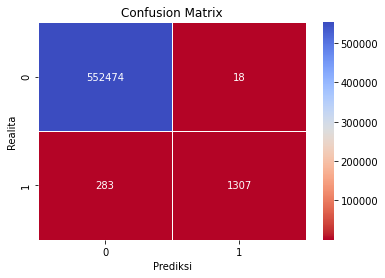

In [80]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

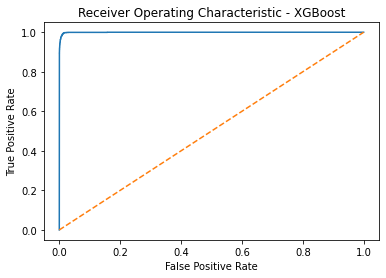

In [81]:
y_score = xgb.predict_proba(X_test_m)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

##### Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train_m, y_train)
y_pred = rfc.predict(X_test_m)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 99.92
Scikit-Learn's Random Forest Classifier's prediction recall is: 0.73
Scikit-Learn's Random Forests Classifier's prediction FPR is: 0.00
Scikit-Learn's Random Forests Classifier's prediction Precision is: 0.99
Scikit-Learn's Random Forests Classifier's prediction auc_score is: 0.87
Scikit-Learn's Random Forests Classifier's prediction fnr is: 0.27
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       0.99      0.73      0.84      1590

    accuracy                           1.00    554082
   macro avg       0.99      0.87      0.92    554082
weighted avg       1.00      1.00      1.00    554082



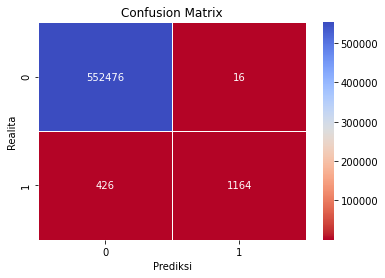

In [83]:
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_rfc = recall_score(y_test, y_pred)
tnr_rfc = recall_score(y_test, y_pred, pos_label = 0)
fpr_rfc = 1 - tnr_rfc
prec_rfc = precision_score(y_test, y_pred)
auc_rfc = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction recall is: %3.2f" % (recall_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction FPR is: %3.2f" % (fpr_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction Precision is: %3.2f" % (prec_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction auc_score is: %3.2f" % (auc_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction fnr is: %3.2f" % (1-recall_rfc))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

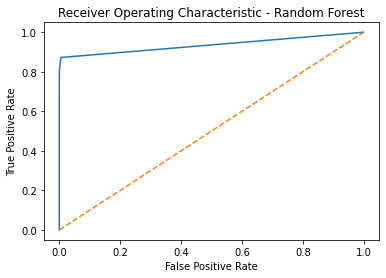

In [84]:
y_score = rfc.predict_proba(X_test_m)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

##### SVM

In [85]:
# from sklearn.svm import SVC
# svc = SVC(probability=True)
# svc.fit(X_train_m, y_train)
# y_pred = svc.predict(X_test_m)

In [86]:
# acc_svc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
# recall_svc = recall_score(y_test, y_pred)
# tnr_svc = recall_score(y_test, y_pred, pos_label = 0)
# fpr_svc = 1 - tnr_svc
# prec_svc = precision_score(y_test, y_pred)
# auc_svc = roc_auc_score(y_test, y_pred)
# print("Scikit-Learn's SVC's prediction accuracy is: %3.2f" % (acc_svc))
# print("Scikit-Learn's SVC's prediction recall is: %3.2f" % (recall_svc))
# print("Scikit-Learn's SVC's prediction FPR is: %3.2f" % (fpr_svc))
# print("Scikit-Learn's SVC's prediction Precision is: %3.2f" % (prec_svc))
# print("Scikit-Learn's SVC's prediction auc_score is: %3.2f" % (auc_svc))
# print("Scikit-Learn's SVC's prediction fnr is: %3.2f" % (1-recall_svc))

# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# print (metrics.classification_report(y_test,y_pred))
# sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
# plt.title('Confusion Matrix')
# plt.xlabel('Prediksi')
# plt.ylabel('Realita')
# plt.savefig('cnf-SVM.png')

In [87]:
# y_score = svc.predict_proba(X_test_m)[:,1]
# false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

# plt.title('Receiver Operating Characteristic - SVM')
# plt.plot(false_positive_rate, true_positive_rate)
# plt.plot([0, 1], ls="--")
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')

# plt.savefig('ROC_SVM.png',dpi=100)
# plt.show()

##### Logistic Regression

In [88]:
logreg = LogisticRegression(class_weight='auto',max_iter=10000)
model=logreg.fit(X_train_m,y_train)
y_pred=logreg.predict(X_test_m)

Scikit-Learn's Logistic Regression's prediction accuracy is: 99.51
Scikit-Learn's Logistic Regression's prediction recall is: 0.13
Scikit-Learn's Logistic Regression's prediction FPR is: 0.00
Scikit-Learn's Logistic Regression's prediction Precision is: 0.14
Scikit-Learn's Logistic Regression's prediction auc_score is: 0.57
Scikit-Learn's Logistic Regression's prediction fnr is: 0.87
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       0.14      0.13      0.14      1590

    accuracy                           1.00    554082
   macro avg       0.57      0.57      0.57    554082
weighted avg       1.00      1.00      1.00    554082



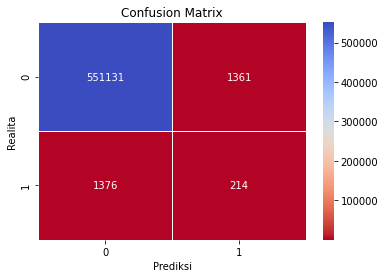

In [89]:
acc_logreg = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_logreg = recall_score(y_test, y_pred)
tnr_logreg = recall_score(y_test, y_pred, pos_label = 0)
fpr_logreg = 1 - tnr_logreg
prec_logreg = precision_score(y_test, y_pred)
auc_logreg = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Logistic Regression's prediction accuracy is: %3.2f" % (acc_logreg))
print("Scikit-Learn's Logistic Regression's prediction recall is: %3.2f" % (recall_logreg))
print("Scikit-Learn's Logistic Regression's prediction FPR is: %3.2f" % (fpr_logreg))
print("Scikit-Learn's Logistic Regression's prediction Precision is: %3.2f" % (prec_logreg))
print("Scikit-Learn's Logistic Regression's prediction auc_score is: %3.2f" % (auc_logreg))
print("Scikit-Learn's Logistic Regression's prediction fnr is: %3.2f" % (1-recall_logreg))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-logreg.png')

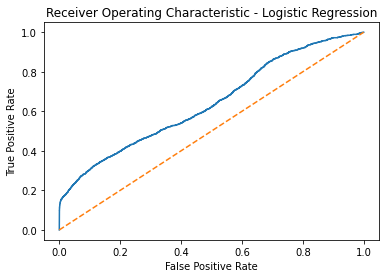

In [90]:
y_score = logreg.predict_proba(X_test_m)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_Logistic.png',dpi=100)
plt.show()

In [91]:
results = pd.DataFrame({
    'Model': [ 
              'XGBoost', 'Random Forest','Logistic Regression'],
    'Recall': [ recall_xgb, recall_rfc,recall_logreg],
    'FPR': [ fpr_xgb, fpr_rfc, fpr_logreg],
    'Accuracy': [ acc_xgb, acc_rfc, acc_logreg],
    'Precission':[ prec_xgb, prec_rfc, prec_logreg],
    'AUC_ROC':[ auc_xgb, auc_rfc, auc_logreg],
    'FNR':[1-recall_xgb, 1-recall_rfc, 1-recall_logreg]})
result_df = results.sort_values(by='Recall', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Recall,FPR,Accuracy,Precission,AUC_ROC,FNR
Model,,,,,,
XGBoost,0.822013,0.000033,99.945676,0.986415,0.910990,0.177987
Random Forest,0.732075,0.000029,99.920228,0.986441,0.866023,0.267925
Logistic Regression,0.134591,0.002463,99.506030,0.135873,0.566064,0.865409


#### with hybridization

##### XGBoost

In [92]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_smenn_m, y_train_smenn)
y_pred = xgb.predict(X_test_smenn_m)

C:\Users\nuzuf\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:13:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Scikit-Learn's XGBoost's prediction accuracy is: 98.45
Scikit-Learn's XGBoost's prediction recall is: 0.92
Scikit-Learn's XGBoost's prediction FPR is: 0.02
Scikit-Learn's XGBoost's prediction Precision is: 0.15
Scikit-Learn's XGBoost's prediction auc_score is: 0.95
Scikit-Learn's XGBoost's prediction fnr is: 0.08
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    552492
           1       0.15      0.92      0.25      1590

    accuracy                           0.98    554082
   macro avg       0.57      0.95      0.62    554082
weighted avg       1.00      0.98      0.99    554082



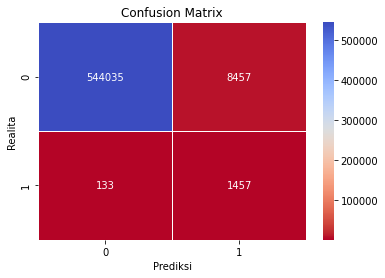

In [93]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

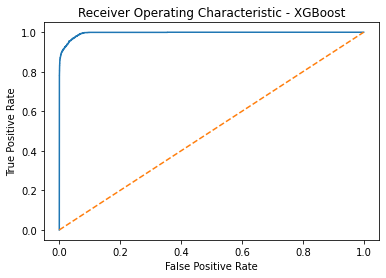

In [94]:
y_score = xgb.predict_proba(X_test_smenn_m)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

##### Random Forest

In [95]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train_smenn_m, y_train_smenn)
y_pred = rfc.predict(X_test_smenn_m)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 99.09
Scikit-Learn's Random Forest Classifier's prediction recall is: 0.85
Scikit-Learn's Random Forests Classifier's prediction FPR is: 0.01
Scikit-Learn's Random Forests Classifier's prediction Precision is: 0.22
Scikit-Learn's Random Forests Classifier's prediction auc_score is: 0.92
Scikit-Learn's Random Forests Classifier's prediction fnr is: 0.15
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    552492
           1       0.22      0.85      0.35      1590

    accuracy                           0.99    554082
   macro avg       0.61      0.92      0.67    554082
weighted avg       1.00      0.99      0.99    554082



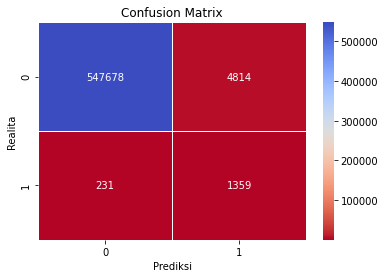

In [96]:
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_rfc = recall_score(y_test, y_pred)
tnr_rfc = recall_score(y_test, y_pred, pos_label = 0)
fpr_rfc = 1 - tnr_rfc
prec_rfc = precision_score(y_test, y_pred)
auc_rfc = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction recall is: %3.2f" % (recall_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction FPR is: %3.2f" % (fpr_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction Precision is: %3.2f" % (prec_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction auc_score is: %3.2f" % (auc_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction fnr is: %3.2f" % (1-recall_rfc))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

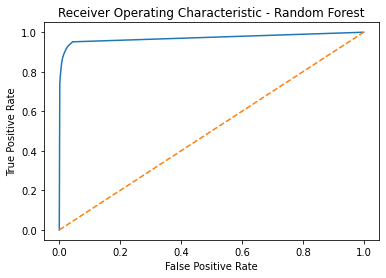

In [97]:
y_score = rfc.predict_proba(X_test_smenn_m)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

##### SVM

In [98]:
# from sklearn.svm import SVC
# svc = SVC(probability=True)
# svc.fit(X_train_smenn_m, y_train_smenn)
# y_pred = svc.predict(X_test_smenn_m)

In [99]:
# acc_svc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
# recall_svc = recall_score(y_test, y_pred)
# tnr_svc = recall_score(y_test, y_pred, pos_label = 0)
# fpr_svc = 1 - tnr_svc
# prec_svc = precision_score(y_test, y_pred)
# auc_svc = roc_auc_score(y_test, y_pred)
# print("Scikit-Learn's SVC's prediction accuracy is: %3.2f" % (acc_svc))
# print("Scikit-Learn's SVC's prediction recall is: %3.2f" % (recall_svc))
# print("Scikit-Learn's SVC's prediction FPR is: %3.2f" % (fpr_svc))
# print("Scikit-Learn's SVC's prediction Precision is: %3.2f" % (prec_svc))
# print("Scikit-Learn's SVC's prediction auc_score is: %3.2f" % (auc_svc))
# print("Scikit-Learn's SVC's prediction fnr is: %3.2f" % (1-recall_svc))

# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# print (metrics.classification_report(y_test,y_pred))
# sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
# plt.title('Confusion Matrix')
# plt.xlabel('Prediksi')
# plt.ylabel('Realita')
# plt.savefig('cnf-SVM.png')

In [100]:
# y_score = svc.predict_proba(X_test_smenn_m)[:,1]
# false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

# plt.title('Receiver Operating Characteristic - SVM')
# plt.plot(false_positive_rate, true_positive_rate)
# plt.plot([0, 1], ls="--")
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')

# plt.savefig('ROC_SVM.png',dpi=100)
# plt.show()

##### Logistic Regression

In [101]:
logreg = LogisticRegression(class_weight='auto',max_iter=10000)
model=logreg.fit(X_train_smenn_m, y_train_smenn)
y_pred=logreg.predict(X_test_smenn_m)

Scikit-Learn's Logistic Regression's prediction accuracy is: 88.77
Scikit-Learn's Logistic Regression's prediction recall is: 0.97
Scikit-Learn's Logistic Regression's prediction FPR is: 0.11
Scikit-Learn's Logistic Regression's prediction Precision is: 0.02
Scikit-Learn's Logistic Regression's prediction auc_score is: 0.93
Scikit-Learn's Logistic Regression's prediction fnr is: 0.03
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    552492
           1       0.02      0.97      0.05      1590

    accuracy                           0.89    554082
   macro avg       0.51      0.93      0.49    554082
weighted avg       1.00      0.89      0.94    554082



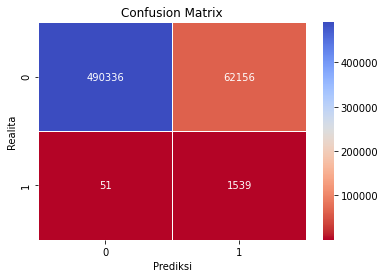

In [102]:
acc_logreg = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_logreg = recall_score(y_test, y_pred)
tnr_logreg = recall_score(y_test, y_pred, pos_label = 0)
fpr_logreg = 1 - tnr_logreg
prec_logreg = precision_score(y_test, y_pred)
auc_logreg = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Logistic Regression's prediction accuracy is: %3.2f" % (acc_logreg))
print("Scikit-Learn's Logistic Regression's prediction recall is: %3.2f" % (recall_logreg))
print("Scikit-Learn's Logistic Regression's prediction FPR is: %3.2f" % (fpr_logreg))
print("Scikit-Learn's Logistic Regression's prediction Precision is: %3.2f" % (prec_logreg))
print("Scikit-Learn's Logistic Regression's prediction auc_score is: %3.2f" % (auc_logreg))
print("Scikit-Learn's Logistic Regression's prediction fnr is: %3.2f" % (1-recall_logreg))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-logreg.png')

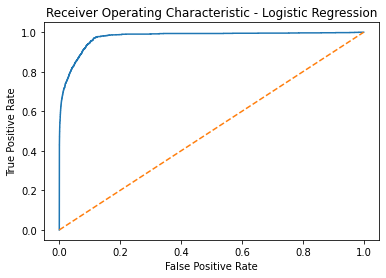

In [103]:
y_score = logreg.predict_proba(X_test_smenn_m)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_Logistic.png',dpi=100)
plt.show()

In [104]:
results = pd.DataFrame({
    'Model': [ 
              'XGBoost', 'Random Forest','Logistic Regression'],
    'Recall': [ recall_xgb, recall_rfc,recall_logreg],
    'FPR': [ fpr_xgb, fpr_rfc, fpr_logreg],
    'Accuracy': [ acc_xgb, acc_rfc, acc_logreg],
    'Precission':[ prec_xgb, prec_rfc, prec_logreg],
    'AUC_ROC':[ auc_xgb, auc_rfc, auc_logreg],
    'FNR':[1-recall_xgb, 1-recall_rfc, 1-recall_logreg]})
result_df = results.sort_values(by='Recall', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Recall,FPR,Accuracy,Precission,AUC_ROC,FNR
Model,,,,,,
Logistic Regression,0.967925,0.112501,88.772961,0.024162,0.927712,0.032075
XGBoost,0.916352,0.015307,98.449688,0.146964,0.950523,0.083648
Random Forest,0.854717,0.008713,99.089485,0.220152,0.923002,0.145283


#### with oversampling

##### XGBoost

In [105]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_sm_m, y_train_sm)
y_pred = xgb.predict(X_test_sm_m)

C:\Users\nuzuf\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:18:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Scikit-Learn's XGBoost's prediction accuracy is: 98.39
Scikit-Learn's XGBoost's prediction recall is: 0.92
Scikit-Learn's XGBoost's prediction FPR is: 0.02
Scikit-Learn's XGBoost's prediction Precision is: 0.14
Scikit-Learn's XGBoost's prediction auc_score is: 0.95
Scikit-Learn's XGBoost's prediction fnr is: 0.08
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    552492
           1       0.14      0.92      0.25      1590

    accuracy                           0.98    554082
   macro avg       0.57      0.95      0.62    554082
weighted avg       1.00      0.98      0.99    554082



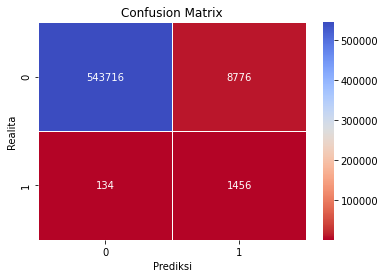

In [106]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

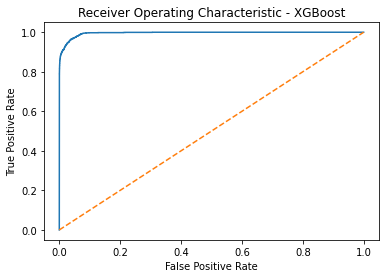

In [107]:
y_score = xgb.predict_proba(X_test_sm_m)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

##### Random Forest

In [108]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train_sm_m, y_train_sm)
y_pred = rfc.predict(X_test_sm_m)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 99.10
Scikit-Learn's Random Forest Classifier's prediction recall is: 0.85
Scikit-Learn's Random Forests Classifier's prediction FPR is: 0.01
Scikit-Learn's Random Forests Classifier's prediction Precision is: 0.22
Scikit-Learn's Random Forests Classifier's prediction auc_score is: 0.92
Scikit-Learn's Random Forests Classifier's prediction fnr is: 0.15
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    552492
           1       0.22      0.85      0.35      1590

    accuracy                           0.99    554082
   macro avg       0.61      0.92      0.67    554082
weighted avg       1.00      0.99      0.99    554082



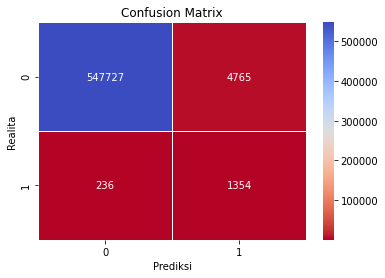

In [109]:
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_rfc = recall_score(y_test, y_pred)
tnr_rfc = recall_score(y_test, y_pred, pos_label = 0)
fpr_rfc = 1 - tnr_rfc
prec_rfc = precision_score(y_test, y_pred)
auc_rfc = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction recall is: %3.2f" % (recall_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction FPR is: %3.2f" % (fpr_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction Precision is: %3.2f" % (prec_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction auc_score is: %3.2f" % (auc_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction fnr is: %3.2f" % (1-recall_rfc))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

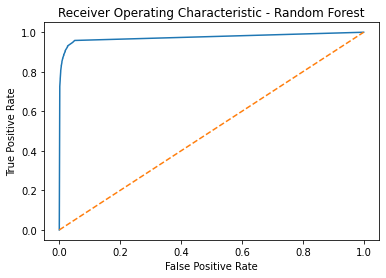

In [110]:
y_score = rfc.predict_proba(X_test_sm_m)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

##### Logistic Regression

In [111]:
logreg = LogisticRegression(class_weight='auto',max_iter=10000)
model=logreg.fit(X_train_sm_m, y_train_sm)
y_pred=logreg.predict(X_test_sm_m)

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 88.76
Scikit-Learn's Gaussian Naive Bayes Classifier's prediction recall is: 0.97
Scikit-Learn's Gaussian Naive Bayes Classifier's prediction FPR is: 0.11
Scikit-Learn's SVC's prediction Precision is: 0.02
Scikit-Learn's SVC's prediction auc_score is: 0.93
Scikit-Learn's SVC's prediction fnr is: 0.03
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    552492
           1       0.02      0.97      0.05      1590

    accuracy                           0.89    554082
   macro avg       0.51      0.93      0.49    554082
weighted avg       1.00      0.89      0.94    554082



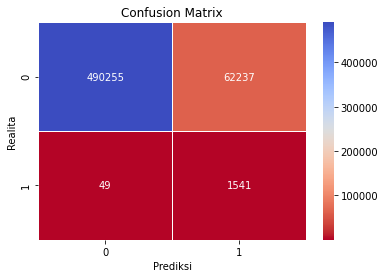

In [112]:
acc_logreg = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_logreg = recall_score(y_test, y_pred)
tnr_logreg = recall_score(y_test, y_pred, pos_label = 0)
fpr_logreg = 1 - tnr_logreg
prec_logreg = precision_score(y_test, y_pred)
auc_logreg = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_logreg))
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction recall is: %3.2f" % (recall_logreg))
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction FPR is: %3.2f" % (fpr_logreg))
print("Scikit-Learn's SVC's prediction Precision is: %3.2f" % (prec_logreg))
print("Scikit-Learn's SVC's prediction auc_score is: %3.2f" % (auc_logreg))
print("Scikit-Learn's SVC's prediction fnr is: %3.2f" % (1-recall_logreg))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-logreg.png')

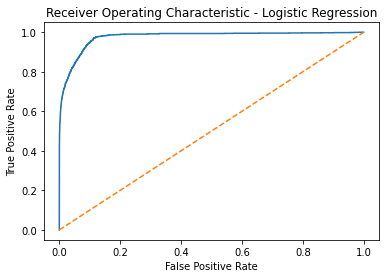

In [113]:
y_score = logreg.predict_proba(X_test_sm_m)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_Logistic.png',dpi=100)
plt.show()

In [114]:
results = pd.DataFrame({
    'Model': [ 
              'XGBoost', 'Random Forest','Logistic Regression'],
    'Recall': [ recall_xgb, recall_rfc,recall_logreg],
    'FPR': [ fpr_xgb, fpr_rfc, fpr_logreg],
    'Accuracy': [ acc_xgb, acc_rfc, acc_logreg],
    'Precission':[ prec_xgb, prec_rfc, prec_logreg],
    'AUC_ROC':[ auc_xgb, auc_rfc, auc_logreg],
    'FNR':[1-recall_xgb, 1-recall_rfc, 1-recall_logreg]})
result_df = results.sort_values(by='Recall', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Recall,FPR,Accuracy,Precission,AUC_ROC,FNR
Model,,,,,,
Logistic Regression,0.969182,0.112648,88.758704,0.024162,0.928267,0.030818
XGBoost,0.915723,0.015884,98.391935,0.142299,0.949919,0.084277
Random Forest,0.851572,0.008625,99.097426,0.221278,0.921474,0.148428


#### with undersampling

##### XGBoost

In [115]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_cnn_m, y_train_cnn)
y_pred = xgb.predict(X_test_cnn_m)

C:\Users\nuzuf\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:25:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Scikit-Learn's XGBoost's prediction accuracy is: 95.39
Scikit-Learn's XGBoost's prediction recall is: 0.93
Scikit-Learn's XGBoost's prediction FPR is: 0.05
Scikit-Learn's XGBoost's prediction Precision is: 0.06
Scikit-Learn's XGBoost's prediction auc_score is: 0.94
Scikit-Learn's XGBoost's prediction fnr is: 0.07
              precision    recall  f1-score   support

           0       1.00      0.95      0.98    552492
           1       0.06      0.93      0.10      1590

    accuracy                           0.95    554082
   macro avg       0.53      0.94      0.54    554082
weighted avg       1.00      0.95      0.97    554082



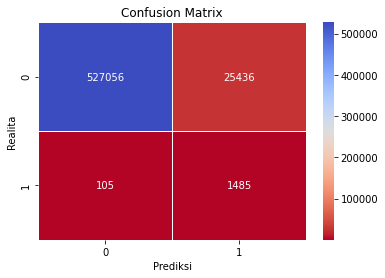

In [116]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

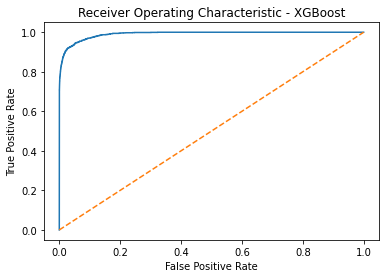

In [117]:
y_score = xgb.predict_proba(X_test_cnn_m)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

##### Random Forest

In [118]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train_cnn_m, y_train_cnn)
y_pred = rfc.predict(X_test_cnn_m)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 97.30
Scikit-Learn's Random Forest Classifier's prediction recall is: 0.91
Scikit-Learn's Random Forests Classifier's prediction FPR is: 0.03
Scikit-Learn's Random Forests Classifier's prediction Precision is: 0.09
Scikit-Learn's Random Forests Classifier's prediction auc_score is: 0.94
Scikit-Learn's Random Forests Classifier's prediction fnr is: 0.09
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    552492
           1       0.09      0.91      0.16      1590

    accuracy                           0.97    554082
   macro avg       0.54      0.94      0.57    554082
weighted avg       1.00      0.97      0.98    554082



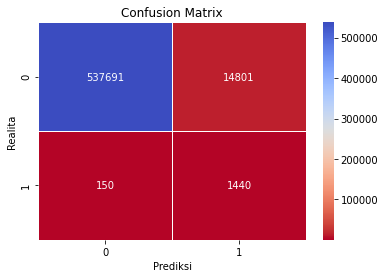

In [119]:
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_rfc = recall_score(y_test, y_pred)
tnr_rfc = recall_score(y_test, y_pred, pos_label = 0)
fpr_rfc = 1 - tnr_rfc
prec_rfc = precision_score(y_test, y_pred)
auc_rfc = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction recall is: %3.2f" % (recall_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction FPR is: %3.2f" % (fpr_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction Precision is: %3.2f" % (prec_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction auc_score is: %3.2f" % (auc_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction fnr is: %3.2f" % (1-recall_rfc))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

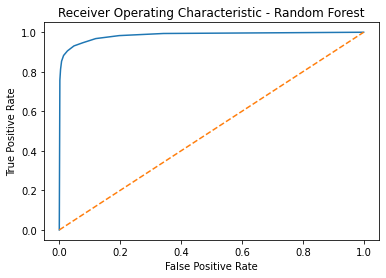

In [120]:
y_score = rfc.predict_proba(X_test_cnn_m)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

##### Logistic Regression

In [121]:
logreg = LogisticRegression(class_weight='auto',max_iter=10000)
model=logreg.fit(X_train_cnn_m, y_train_cnn)
y_pred=logreg.predict(X_test_cnn_m)

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 87.62
Scikit-Learn's Gaussian Naive Bayes Classifier's prediction recall is: 0.94
Scikit-Learn's Gaussian Naive Bayes Classifier's prediction FPR is: 0.12
Scikit-Learn's SVC's prediction Precision is: 0.02
Scikit-Learn's SVC's prediction auc_score is: 0.91
Scikit-Learn's SVC's prediction fnr is: 0.06
              precision    recall  f1-score   support

           0       1.00      0.88      0.93    552492
           1       0.02      0.94      0.04      1590

    accuracy                           0.88    554082
   macro avg       0.51      0.91      0.49    554082
weighted avg       1.00      0.88      0.93    554082



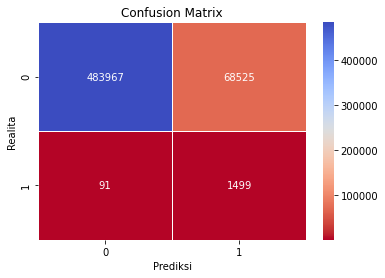

In [122]:
acc_logreg = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_logreg = recall_score(y_test, y_pred)
tnr_logreg = recall_score(y_test, y_pred, pos_label = 0)
fpr_logreg = 1 - tnr_logreg
prec_logreg = precision_score(y_test, y_pred)
auc_logreg = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_logreg))
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction recall is: %3.2f" % (recall_logreg))
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction FPR is: %3.2f" % (fpr_logreg))
print("Scikit-Learn's SVC's prediction Precision is: %3.2f" % (prec_logreg))
print("Scikit-Learn's SVC's prediction auc_score is: %3.2f" % (auc_logreg))
print("Scikit-Learn's SVC's prediction fnr is: %3.2f" % (1-recall_logreg))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-logreg.png')

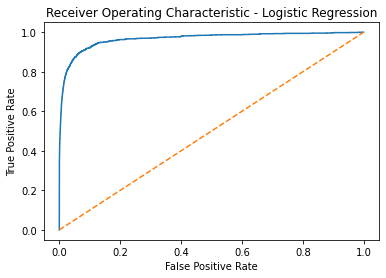

In [123]:
y_score = logreg.predict_proba(X_test_cnn_m)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_Logistic.png',dpi=100)
plt.show()

In [124]:
results = pd.DataFrame({
    'Model': [ 
              'XGBoost', 'Random Forest','Logistic Regression'],
    'Recall': [ recall_xgb, recall_rfc,recall_logreg],
    'FPR': [ fpr_xgb, fpr_rfc, fpr_logreg],
    'Accuracy': [ acc_xgb, acc_rfc, acc_logreg],
    'Precission':[ prec_xgb, prec_rfc, prec_logreg],
    'AUC_ROC':[ auc_xgb, auc_rfc, auc_logreg],
    'FNR':[1-recall_xgb, 1-recall_rfc, 1-recall_logreg]})
result_df = results.sort_values(by='Recall', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Recall,FPR,Accuracy,Precission,AUC_ROC,FNR
Model,,,,,,
Logistic Regression,0.942767,0.124029,87.616273,0.021407,0.909369,0.057233
XGBoost,0.933962,0.046039,95.390393,0.055161,0.943962,0.066038
Random Forest,0.905660,0.026790,97.301663,0.088664,0.939435,0.094340


### K-Fold Cross Validation

いくつかのモデルの中で一番良いのはRandom Forest With Oversampling、このモデルによるCross Validation を実施。

In [176]:
t = [0,1]
X.iloc[t]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.0,181.0,0.0,0.0,0.0,0.0,181.0
3,1,1,181.0,181.0,0.0,21182.0,0.0,0.0,21363.0


In [184]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

kf = StratifiedKFold(n_splits=10)

X_val_res = X_val.reset_index(drop=True)
y_val_res = y_val.reset_index(drop=True)
acc = []
recall = []
fpr = []
prec = []
auc = []

for fold, (train, validation) in enumerate(kf.split(X_val_res, y_val_res)):
    X_val_res_train = X_val_res.iloc[train]
    y_val_res_train = y_val_res.iloc[train]  
    X_val_res_test = X_val_res.iloc[validation]
    y_val_res_test = y_val_res.iloc[validation] 
    sm = SMOTE()
    X_val_res_train, y_val_res_train = sm.fit_resample(X_val_res_train, y_val_res_train)
    model = RandomForestClassifier(n_estimators=10)
    model.fit(X_val_res_train,y_val_res_train)
    y_pred = model.predict(X_val_res_test)
    acc_rfc = model.score(X_val_res_test,y_val_res_test)
    recall_rfc = recall_score(y_val_res_test, y_pred)
    tnr_rfc = recall_score(y_val_res_test, y_pred, pos_label = 0)
    fpr_rfc = 1 - tnr_rfc
    prec_rfc = precision_score(y_val_res_test, y_pred)
    auc_rfc = roc_auc_score(y_val_res_test, y_pred) 
    acc.append(acc_rfc)
    recall.append(recall_rfc)
    fpr.append(fpr_rfc)
    prec.append(prec_rfc)
    auc.append(auc_rfc)
    print('Fold: %2d, recall: %.3f, precission: %.3f, fpr: %.3f, auc: %.3f Accuracy: %.3f' % (fold+1, recall_rfc,prec_rfc,fpr_rfc,auc_rfc, acc_rfc,))
    


Fold:  1, recall: 0.998, precission: 0.976, fpr: 0.000, auc: 0.999 Accuracy: 1.000
Fold:  2, recall: 0.995, precission: 0.978, fpr: 0.000, auc: 0.998 Accuracy: 1.000
Fold:  3, recall: 0.998, precission: 0.979, fpr: 0.000, auc: 0.999 Accuracy: 1.000
Fold:  4, recall: 0.995, precission: 0.976, fpr: 0.000, auc: 0.998 Accuracy: 1.000
Fold:  5, recall: 0.995, precission: 0.981, fpr: 0.000, auc: 0.998 Accuracy: 1.000
Fold:  6, recall: 0.994, precission: 0.967, fpr: 0.000, auc: 0.997 Accuracy: 1.000
Fold:  7, recall: 0.995, precission: 0.981, fpr: 0.000, auc: 0.998 Accuracy: 1.000
Fold:  8, recall: 0.997, precission: 0.976, fpr: 0.000, auc: 0.998 Accuracy: 1.000
Fold:  9, recall: 0.995, precission: 0.982, fpr: 0.000, auc: 0.998 Accuracy: 1.000
Fold: 10, recall: 0.998, precission: 0.970, fpr: 0.000, auc: 0.999 Accuracy: 1.000


In [185]:
print('Cross Validation: recall: %.3f, precission: %.3f, fpr: %.3f, auc: %.3f Accuracy: %.3f' % (np.mean(recall_rfc)*100,
    np.mean(prec_rfc)*100,np.mean(fpr_rfc)*100,np.mean(auc_rfc)*100,np.mean(acc_rfc)*100))
    

Cross Validation: recall: 99.848, precission: 97.037, fpr: 0.009, auc: 99.919 Accuracy: 99.991


In [ ]:
for fold, (train_index, test_index) in enumerate(kf.split(X_val,y_val), 1):
    X_train = X[train_index]
    y_train = y[train_index]  
    X_test = X[test_index]
    y_test = y[test_index]  
    sm = SMOTE()
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
    model = ...  # Choose a model here
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred = model.predict(X_test)
    print(f'For fold {fold}:')
    print(f'Accuracy: {model.score(X_test, y_test)}')
    print(f'f-score: {f1_score(y_test, y_pred)}')

Grid Search (XGBoost All Features and with oversampling)

In [125]:
# from sklearn.model_selection import GridSearchCV
# #X_train_m, y_train_m = X_train_m.tolist(),y_train_m.tolist()
# params = { 'max_depth': [3,6,10],
#            'learning_rate': [0.01, 0.05, 0.1],
#            'n_estimators': [100, 500, 1000],
#            'colsample_bytree': [0.3, 0.7]}
# xgb = XGBClassifier(seed = 20)
# clf = GridSearchCV(estimator=xgb, 
#                    param_grid=params,
#                    scoring='neg_mean_squared_error', 
#                    verbose=1)
# clf.fit(X_train_smenn, y_train_smenn)
# print("Best parameters:", clf.best_params_)
# print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In [126]:
# from xgboost import XGBClassifier
# xgb = XGBClassifier(**clf.best_params_)
# xgb.fit(X_train_smenn, y_train_smenn)
# y_pred_m = xgb.predict(X_test)


In [127]:
# acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
# recall_xgb = recall_score(y_test, y_pred)
# tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
# fpr_xgb = 1 - tnr_xgb
# prec_xgb = precision_score(y_test, y_pred)
# auc_xgb = roc_auc_score(y_test, y_pred)
# print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
# print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
# print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
# print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
# print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
# print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# print (metrics.classification_report(y_test,y_pred))
# sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
# plt.title('Confusion Matrix')
# plt.xlabel('Prediksi')
# plt.ylabel('Realita')
# plt.savefig('cnf-xgb.png')

In [128]:
# y_score = xgb.predict_proba(X_test)[:,1]
# false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

# plt.title('Receiver Operating Characteristic - XGBoost')
# plt.plot(false_positive_rate, true_positive_rate)
# plt.plot([0, 1], ls="--")
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')


# plt.savefig('ROC_XGB.png',dpi=100)
# plt.show()

### KNN (Outlier Detection)

In [ ]:
import pyod
from pyod.models.knn import KNN
knn = KNN()
knn.fit(X_train)


KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [ ]:
y_pred = knn.predict(X_test)

KNN's prediction accuracy is: 89.92
KNN's prediction recall is: 0.28
KNN's prediction FPR is: 0.10
KNN's prediction Precision is: 0.01
KNN's prediction auc_score is: 0.59
KNN's prediction fnr is: 0.72
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    552492
           1       0.01      0.28      0.02      1590

    accuracy                           0.90    554082
   macro avg       0.50      0.59      0.48    554082
weighted avg       0.99      0.90      0.94    554082



Text(33.0, 0.5, 'Realita')

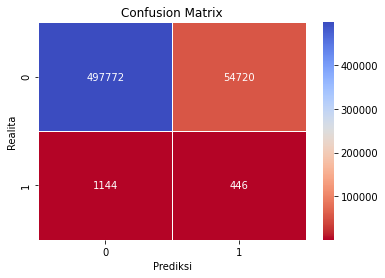

In [ ]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("KNN's prediction accuracy is: %3.2f" % (acc_xgb))
print("KNN's prediction recall is: %3.2f" % (recall_xgb))
print("KNN's prediction FPR is: %3.2f" % (fpr_xgb))
print("KNN's prediction Precision is: %3.2f" % (prec_xgb))
print("KNN's prediction auc_score is: %3.2f" % (auc_xgb))
print("KNN's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
# plt.savefig('cnf-xgb.png')

### PCA(Model)

#### without oversampling

##### XGBoost

In [373]:
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [374]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_pca_train_, y_train)


C:\Users\nuzuf\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:11:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [375]:
y_pred = xgb.predict(X_pca_test_)


Scikit-Learn's XGBoost's prediction accuracy is: 99.76
Scikit-Learn's XGBoost's prediction recall is: 0.18
Scikit-Learn's XGBoost's prediction FPR is: 0.00
Scikit-Learn's XGBoost's prediction Precision is: 0.96
Scikit-Learn's XGBoost's prediction auc_score is: 0.59
Scikit-Learn's XGBoost's prediction fnr is: 0.82
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       0.96      0.18      0.31      1590

    accuracy                           1.00    554082
   macro avg       0.98      0.59      0.65    554082
weighted avg       1.00      1.00      1.00    554082



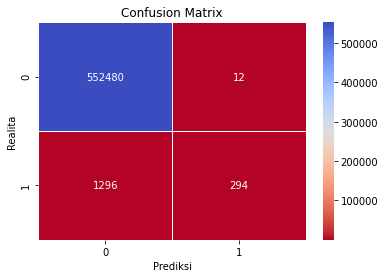

In [376]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

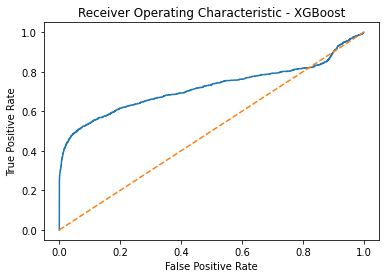

In [377]:
y_score = xgb.predict_proba(X_pca_test_)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

##### Random Forest

In [378]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_pca_train_, y_train)
y_pred = rfc.predict(X_pca_test_)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 99.76
Scikit-Learn's Random Forest Classifier's prediction recall is: 0.16
Scikit-Learn's Random Forests Classifier's prediction FPR is: 0.00
Scikit-Learn's Random Forests Classifier's prediction Precision is: 0.97
Scikit-Learn's Random Forests Classifier's prediction auc_score is: 0.58
Scikit-Learn's Random Forests Classifier's prediction fnr is: 0.84
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       0.97      0.16      0.27      1590

    accuracy                           1.00    554082
   macro avg       0.98      0.58      0.64    554082
weighted avg       1.00      1.00      1.00    554082



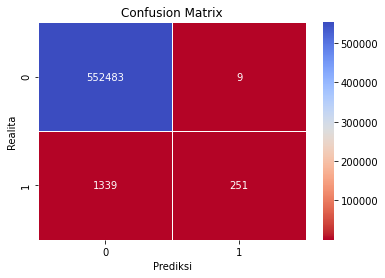

In [379]:
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_rfc = recall_score(y_test, y_pred)
tnr_rfc = recall_score(y_test, y_pred, pos_label = 0)
fpr_rfc = 1 - tnr_rfc
prec_rfc = precision_score(y_test, y_pred)
auc_rfc = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction recall is: %3.2f" % (recall_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction FPR is: %3.2f" % (fpr_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction Precision is: %3.2f" % (prec_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction auc_score is: %3.2f" % (auc_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction fnr is: %3.2f" % (1-recall_rfc))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

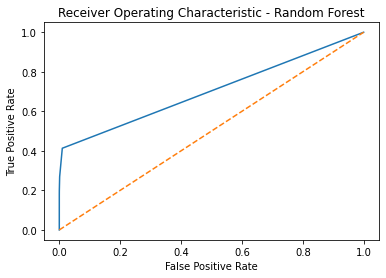

In [380]:
y_score = rfc.predict_proba(X_pca_test_)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

##### Logistic Regression

In [381]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(class_weight='auto',max_iter=10000)
model=logreg.fit(X_pca_train_,y_train)
y_pred=logreg.predict(X_pca_test_)

Scikit-Learn's Logistic Regression's prediction accuracy is: 99.72
Scikit-Learn's Logistic Regression's prediction recall is: 0.04
Scikit-Learn's Logistic Regression's prediction FPR is: 0.00
Scikit-Learn's Logistic Regression's prediction Precision is: 0.99
Scikit-Learn's Logistic Regression's prediction auc_score is: 0.52
Scikit-Learn's Logistic Regression's prediction fnr is: 0.96
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       0.99      0.04      0.08      1590

    accuracy                           1.00    554082
   macro avg       0.99      0.52      0.54    554082
weighted avg       1.00      1.00      1.00    554082



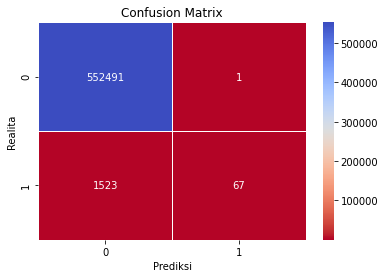

In [382]:
acc_logreg = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_logreg = recall_score(y_test, y_pred)
tnr_logreg = recall_score(y_test, y_pred, pos_label = 0)
fpr_logreg = 1 - tnr_logreg
prec_logreg = precision_score(y_test, y_pred)
auc_logreg = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Logistic Regression's prediction accuracy is: %3.2f" % (acc_logreg))
print("Scikit-Learn's Logistic Regression's prediction recall is: %3.2f" % (recall_logreg))
print("Scikit-Learn's Logistic Regression's prediction FPR is: %3.2f" % (fpr_logreg))
print("Scikit-Learn's Logistic Regression's prediction Precision is: %3.2f" % (prec_logreg))
print("Scikit-Learn's Logistic Regression's prediction auc_score is: %3.2f" % (auc_logreg))
print("Scikit-Learn's Logistic Regression's prediction fnr is: %3.2f" % (1-recall_logreg))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-logreg.png')

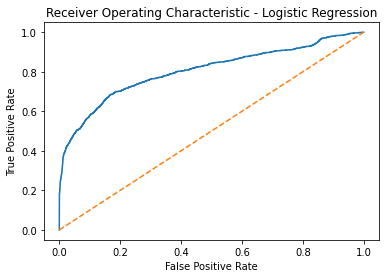

In [383]:
y_score = logreg.predict_proba(X_pca_test_)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_Logistic.png',dpi=100)
plt.show()

In [384]:
results = pd.DataFrame({
    'Model': [ 
              'XGBoost', 'Random Forest','Logistic Regression'],
    'Recall': [ recall_xgb, recall_rfc,recall_logreg],
    'FPR': [ fpr_xgb, fpr_rfc, fpr_logreg],
    'Accuracy': [ acc_xgb, acc_rfc, acc_logreg],
    'Precission':[ prec_xgb, prec_rfc, prec_logreg],
    'AUC_ROC':[ auc_xgb, auc_rfc, auc_logreg],
    'FNR':[1-recall_xgb, 1-recall_rfc, 1-recall_logreg]})
result_df = results.sort_values(by='Recall', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Recall,FPR,Accuracy,Precission,AUC_ROC,FNR
Model,,,,,,
XGBoost,0.184906,0.000022,99.763934,0.960784,0.592442,0.815094
Random Forest,0.157862,0.000016,99.756715,0.965385,0.578923,0.842138
Logistic Regression,0.042138,0.000002,99.724950,0.985294,0.521068,0.957862


#### with oversampling

##### XGBoost

In [385]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_pca_train_sm_, y_train_sm)
y_pred = xgb.predict(X_pca_test_)

C:\Users\nuzuf\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:14:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Scikit-Learn's XGBoost's prediction accuracy is: 85.49
Scikit-Learn's XGBoost's prediction recall is: 0.19
Scikit-Learn's XGBoost's prediction FPR is: 0.14
Scikit-Learn's XGBoost's prediction Precision is: 0.00
Scikit-Learn's XGBoost's prediction auc_score is: 0.52
Scikit-Learn's XGBoost's prediction fnr is: 0.81
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    552492
           1       0.00      0.19      0.01      1590

    accuracy                           0.85    554082
   macro avg       0.50      0.52      0.46    554082
weighted avg       0.99      0.85      0.92    554082



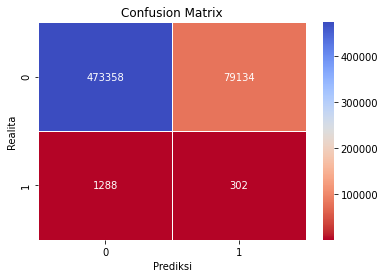

In [386]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_xgb = recall_score(y_test, y_pred)
tnr_xgb = recall_score(y_test, y_pred, pos_label = 0)
fpr_xgb = 1 - tnr_xgb
prec_xgb = precision_score(y_test, y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Scikit-Learn's XGBoost's prediction recall is: %3.2f" % (recall_xgb))
print("Scikit-Learn's XGBoost's prediction FPR is: %3.2f" % (fpr_xgb))
print("Scikit-Learn's XGBoost's prediction Precision is: %3.2f" % (prec_xgb))
print("Scikit-Learn's XGBoost's prediction auc_score is: %3.2f" % (auc_xgb))
print("Scikit-Learn's XGBoost's prediction fnr is: %3.2f" % (1-recall_xgb))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-xgb.png')

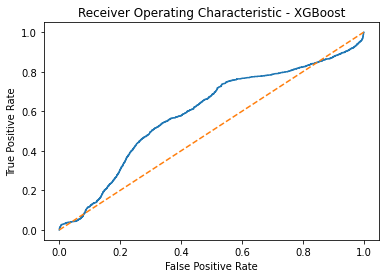

In [387]:
y_score = xgb.predict_proba(X_pca_test_)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - XGBoost')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_XGB.png',dpi=100)
plt.show()

##### Random Forest

In [388]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_pca_train_sm_, y_train_sm)
y_pred = rfc.predict(X_pca_test_)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 91.14
Scikit-Learn's Random Forest Classifier's prediction recall is: 0.18
Scikit-Learn's Random Forests Classifier's prediction FPR is: 0.09
Scikit-Learn's Random Forests Classifier's prediction Precision is: 0.01
Scikit-Learn's Random Forests Classifier's prediction auc_score is: 0.55
Scikit-Learn's Random Forests Classifier's prediction fnr is: 0.82
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    552492
           1       0.01      0.18      0.01      1590

    accuracy                           0.91    554082
   macro avg       0.50      0.55      0.48    554082
weighted avg       0.99      0.91      0.95    554082



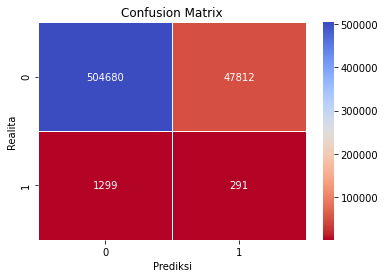

In [389]:
acc_rfc = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_rfc = recall_score(y_test, y_pred)
tnr_rfc = recall_score(y_test, y_pred, pos_label = 0)
fpr_rfc = 1 - tnr_rfc
prec_rfc = precision_score(y_test, y_pred)
auc_rfc = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction recall is: %3.2f" % (recall_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction FPR is: %3.2f" % (fpr_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction Precision is: %3.2f" % (prec_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction auc_score is: %3.2f" % (auc_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction fnr is: %3.2f" % (1-recall_rfc))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

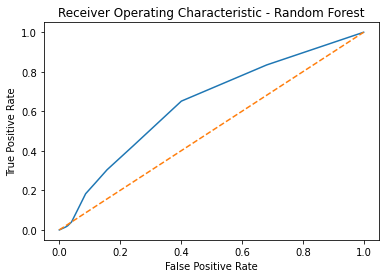

In [390]:
y_score = rfc.predict_proba(X_pca_test_)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

##### Logistic Regression

In [391]:
logreg = LogisticRegression(class_weight='auto',max_iter=10000)
model=logreg.fit(X_pca_train_sm_, y_train_sm)
y_pred=logreg.predict(X_pca_test_)

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 47.27
Scikit-Learn's Gaussian Naive Bayes Classifier's prediction recall is: 0.84
Scikit-Learn's Gaussian Naive Bayes Classifier's prediction FPR is: 0.53
Scikit-Learn's SVC's prediction Precision is: 0.00
Scikit-Learn's SVC's prediction auc_score is: 0.65
Scikit-Learn's SVC's prediction fnr is: 0.16
              precision    recall  f1-score   support

           0       1.00      0.47      0.64    552492
           1       0.00      0.84      0.01      1590

    accuracy                           0.47    554082
   macro avg       0.50      0.65      0.32    554082
weighted avg       1.00      0.47      0.64    554082



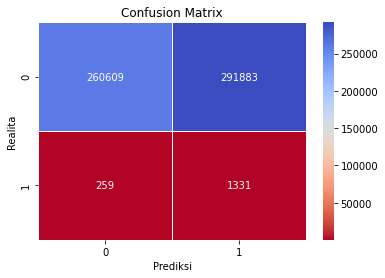

In [392]:
acc_logreg = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
recall_logreg = recall_score(y_test, y_pred)
tnr_logreg = recall_score(y_test, y_pred, pos_label = 0)
fpr_logreg = 1 - tnr_logreg
prec_logreg = precision_score(y_test, y_pred)
auc_logreg = roc_auc_score(y_test, y_pred)
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_logreg))
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction recall is: %3.2f" % (recall_logreg))
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction FPR is: %3.2f" % (fpr_logreg))
print("Scikit-Learn's SVC's prediction Precision is: %3.2f" % (prec_logreg))
print("Scikit-Learn's SVC's prediction auc_score is: %3.2f" % (auc_logreg))
print("Scikit-Learn's SVC's prediction fnr is: %3.2f" % (1-recall_logreg))


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print (metrics.classification_report(y_test,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-logreg.png')

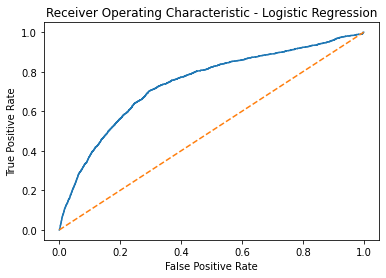

In [393]:
y_score = logreg.predict_proba(X_pca_test_)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)

plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('ROC_Logistic.png',dpi=100)
plt.show()

In [394]:
results = pd.DataFrame({
    'Model': [ 
              'XGBoost', 'Random Forest','Logistic Regression'],
    'Recall': [ recall_xgb, recall_rfc,recall_logreg],
    'FPR': [ fpr_xgb, fpr_rfc, fpr_logreg],
    'Accuracy': [ acc_xgb, acc_rfc, acc_logreg],
    'Precission':[ prec_xgb, prec_rfc, prec_logreg],
    'AUC_ROC':[ auc_xgb, auc_rfc, auc_logreg],
    'FNR':[1-recall_xgb, 1-recall_rfc, 1-recall_logreg]})
result_df = results.sort_values(by='Recall', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Recall,FPR,Accuracy,Precission,AUC_ROC,FNR
Model,,,,,,
Logistic Regression,0.837107,0.528303,47.274591,0.004539,0.654402,0.162893
XGBoost,0.189937,0.143231,85.485542,0.003802,0.523353,0.810063
Random Forest,0.183019,0.086539,91.136510,0.006050,0.548240,0.816981


### Backtesting

#### Random Forest all features without over/undersampling

In [397]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_backtest)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 100.00
Scikit-Learn's Random Forest Classifier's prediction recall is: 0.99
Scikit-Learn's Random Forests Classifier's prediction FPR is: 0.00
Scikit-Learn's Random Forests Classifier's prediction Precision is: 1.00
Scikit-Learn's Random Forests Classifier's prediction auc_score is: 1.00
Scikit-Learn's Random Forests Classifier's prediction fnr is: 0.01
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       1.00      0.99      1.00      1646

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



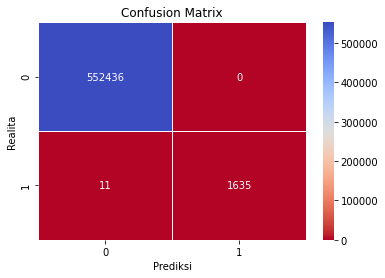

In [398]:
acc_rfc = (y_pred == y_backtest).sum().astype(float) / len(y_pred)*100
recall_rfc = recall_score(y_backtest, y_pred)
tnr_rfc = recall_score(y_backtest, y_pred, pos_label = 0)
fpr_rfc = 1 - tnr_rfc
prec_rfc = precision_score(y_backtest, y_pred)
auc_rfc = roc_auc_score(y_backtest, y_pred)
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction recall is: %3.2f" % (recall_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction FPR is: %3.2f" % (fpr_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction Precision is: %3.2f" % (prec_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction auc_score is: %3.2f" % (auc_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction fnr is: %3.2f" % (1-recall_rfc))

cnf_matrix = metrics.confusion_matrix(y_backtest, y_pred)
print (metrics.classification_report(y_backtest,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

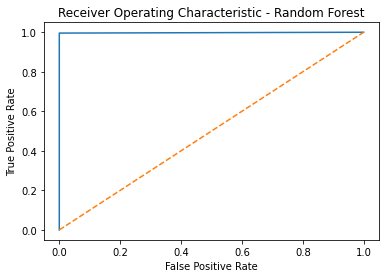

In [399]:
y_score = rfc.predict_proba(X_backtest)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_backtest, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()

In [406]:
# from sklearn.tree import export_graphviz
# from sklearn import tree

# fn=features = list(X.columns)
# cn=y_train

# cn=[str(x) for x in cn]

# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)

# tree.plot_tree(rfc,
#                feature_names = fn, 
#                class_names=cn,
#                filled = False);
# fig.savefig('rf_individualtree.png')

#### Random Forest all features with oversampling

In [407]:
from sklearn.ensemble import RandomForestClassifier
rfc01 = RandomForestClassifier(n_estimators=10)
rfc01.fit(X_train_sm, y_train_sm)
y_pred = rfc01.predict(X_backtest)

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 99.99
Scikit-Learn's Random Forest Classifier's prediction recall is: 0.99
Scikit-Learn's Random Forests Classifier's prediction FPR is: 0.00
Scikit-Learn's Random Forests Classifier's prediction Precision is: 0.97
Scikit-Learn's Random Forests Classifier's prediction auc_score is: 1.00
Scikit-Learn's Random Forests Classifier's prediction fnr is: 0.01
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.97      0.99      0.98      1646

    accuracy                           1.00    554082
   macro avg       0.98      1.00      0.99    554082
weighted avg       1.00      1.00      1.00    554082



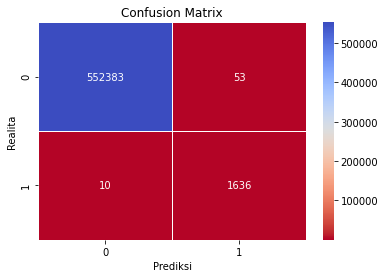

In [408]:
acc_rfc = (y_pred == y_backtest).sum().astype(float) / len(y_pred)*100
recall_rfc = recall_score(y_backtest, y_pred)
tnr_rfc = recall_score(y_backtest, y_pred, pos_label = 0)
fpr_rfc = 1 - tnr_rfc
prec_rfc = precision_score(y_backtest, y_pred)
auc_rfc = roc_auc_score(y_backtest, y_pred)
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Scikit-Learn's Random Forest Classifier's prediction recall is: %3.2f" % (recall_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction FPR is: %3.2f" % (fpr_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction Precision is: %3.2f" % (prec_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction auc_score is: %3.2f" % (auc_rfc))
print("Scikit-Learn's Random Forests Classifier's prediction fnr is: %3.2f" % (1-recall_rfc))

cnf_matrix = metrics.confusion_matrix(y_backtest, y_pred)
print (metrics.classification_report(y_backtest,y_pred))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Realita')
plt.savefig('cnf-RF.png')

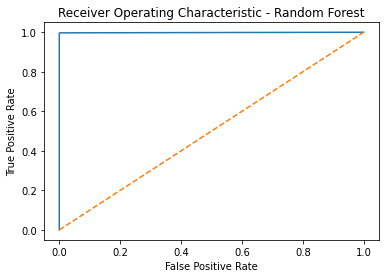

In [409]:
y_score = rfc01.predict_proba(X_backtest)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_backtest, y_score)

plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.savefig('ROC_RF.png',dpi=100)
plt.show()